# Analysis of the expression values for the Covid example
- This notebook reads the output of the Seurat summarize cluster
- Displays it as FlowSets
- Analyses genes differential in the first state with pathway enrichment

Content from Paper Figure 2
---
Author: Markus Joppich

In [1]:
# Enable autoreload for development (reloads modules before executing code)
%load_ext autoreload

# Set up Python path to include parent directory for local imports
import os, sys

# Automatically reload modules before executing code
%autoreload 2
from flowsets import *

# Import polars for fast DataFrame operations
import polars as pl

# Set matplotlib to produce high-resolution figures
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 300

In [2]:
# Utility function to download and unzip a file if not present
# Used to fetch ReactomePathways.gmt if missing
def download_and_unzip(download_url_link, dir_path, zipped_filename, destination_dir_name):
    # https://www.tutorialsbuddy.com/download-and-unzip-a-zipped-file-in-python
    print("Download starting")
    urllib.request.urlretrieve(
        download_url_link, os.path.join(dir_path, zipped_filename)
    )
    print("Download complete")

    print("unzipping file starting")
    with zipfile.ZipFile(os.path.join(dir_path, zipped_filename), "r") as zip_file:
        zip_file.extractall(os.path.join(dir_path, destination_dir_name))
    print("unzipping complete")

# Download ReactomePathways.gmt if not already present
if not os.path.exists("ReactomePathways.gmt"):
    download_and_unzip("https://reactome.org/download/current/ReactomePathways.gmt.zip", ".", "ReactomePathways.gmt.zip", ".")

In [3]:
# Load and filter single-cell COVID-19 expression data
# Remove cluster 0 (likely background or reference cluster)
exprData = pl.read_csv("sccovid_data/expression.mono.asympt.tsv", has_header=True, separator="\t", null_values=["NA"])
exprData = exprData.filter( pl.col("cluster") != "cluster.0")
print(exprData)

# Uncomment to inspect unique clusters
# print(exprData.select("cluster").unique())

shape: (40_795, 13)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬──────────┬───────────┬───────────┐
│ cluster   ┆ count_exp ┆ min.clust ┆ lower_hin ┆ … ┆ count_all ┆ gene     ┆ not_expr. ┆ expr.clus │
│ ---       ┆ r.cluster ┆ er        ┆ ge.cluste ┆   ┆ .cluster  ┆ ---      ┆ cluster   ┆ ter       │
│ str       ┆ ---       ┆ ---       ┆ r         ┆   ┆ ---       ┆ str      ┆ ---       ┆ ---       │
│           ┆ i64       ┆ f64       ┆ ---       ┆   ┆ i64       ┆          ┆ f64       ┆ f64       │
│           ┆           ┆           ┆ f64       ┆   ┆           ┆          ┆           ┆           │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪══════════╪═══════════╪═══════════╡
│ cluster.1 ┆ 33        ┆ 0.520254  ┆ 0.741529  ┆ … ┆ 131       ┆ HES4     ┆ 0.748092  ┆ 0.251908  │
│ cluster.1 ┆ 118       ┆ 0.520891  ┆ 2.091211  ┆ … ┆ 131       ┆ ISG15    ┆ 0.099237  ┆ 0.900763  │
│ cluster.1 ┆ 17        ┆ 0.447013  ┆ 0.644771  ┆ … ┆ 131       ┆ AGRN 

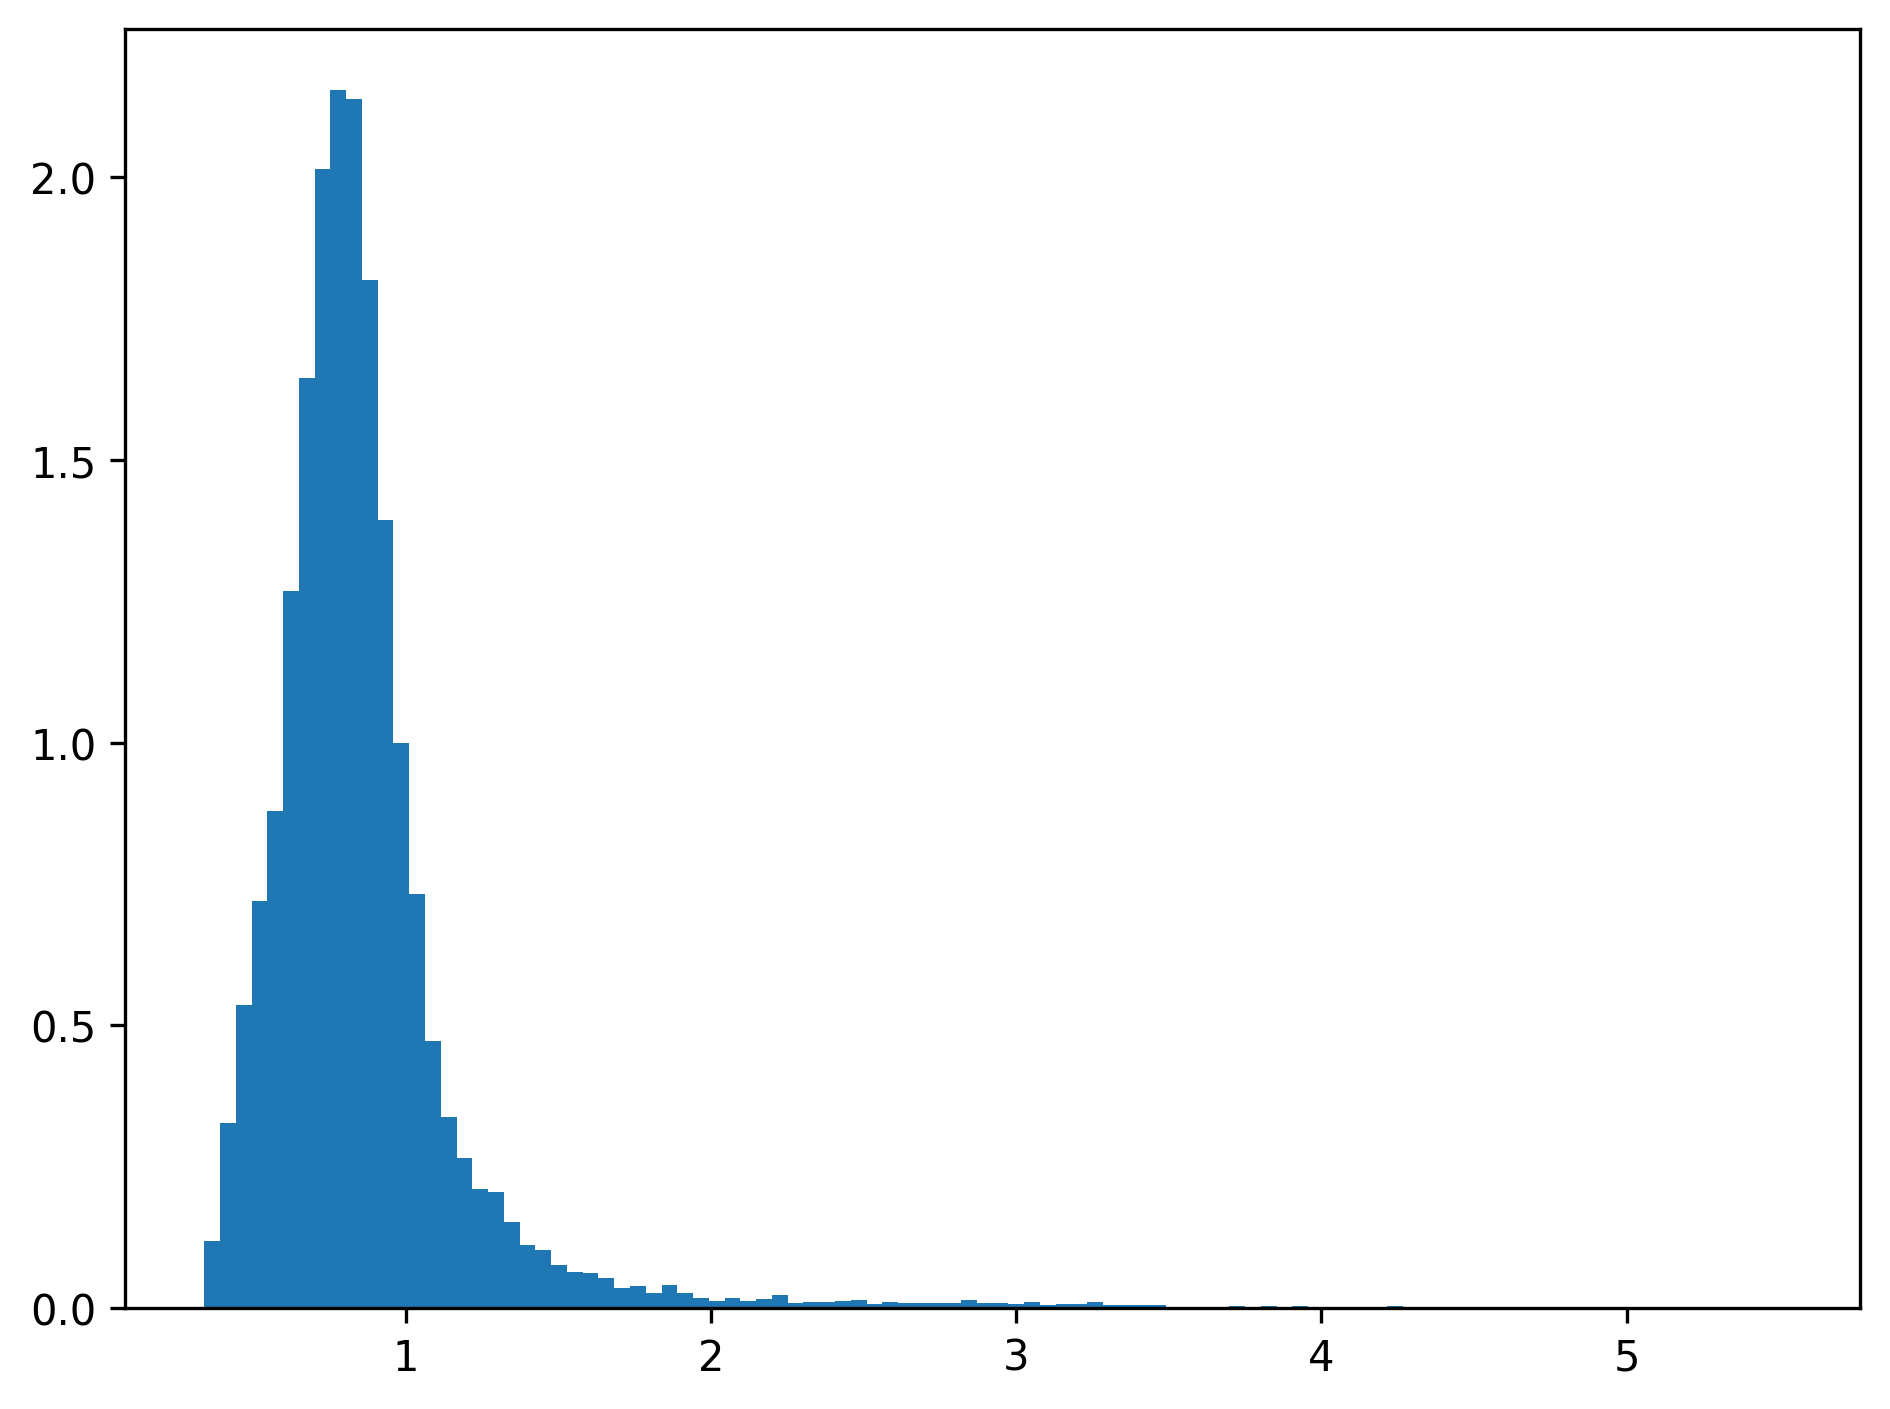

In [4]:
# Helper function to plot histogram of a column in a polars DataFrame
def pl_hist(df, column, n_bins=100,):
    data = df.select(pl.col(column))
    
    fig, ax = plt.subplots(1, 1, tight_layout=True)
    ax.hist(data, bins=n_bins, density=True)
    
    plt.show()
    plt.close()
    
# Plot histogram of mean expression values per cluster
pl_hist(exprData, "mean.cluster")

In [5]:
# Initialize the legacy fuzzifier for fuzzy logic transformation
lfz = LegacyFuzzifier()

centers [0.4, 0.8, 1.2, 1.6, 2, 2.4]
Creating Universe Range 0.0 -> 8.0 with step size 0.1
Mean Expr mean.cluster col 7
Expr Count expr.cluster col 12
SD sd.cluster col 8
Cluster cluster col 0
Combining over state:  False


/home/o/offensperger/.local/lib/python3.12/site-packages/flowsets/flowsets.py:661: RuntimeWarning: invalid value encountered in divide
  values = fuzz.trimf(self.universe, abc)/unscaledValues


to_homogeneous: cluster.3
to_homogeneous: cluster.1
to_homogeneous: cluster.2


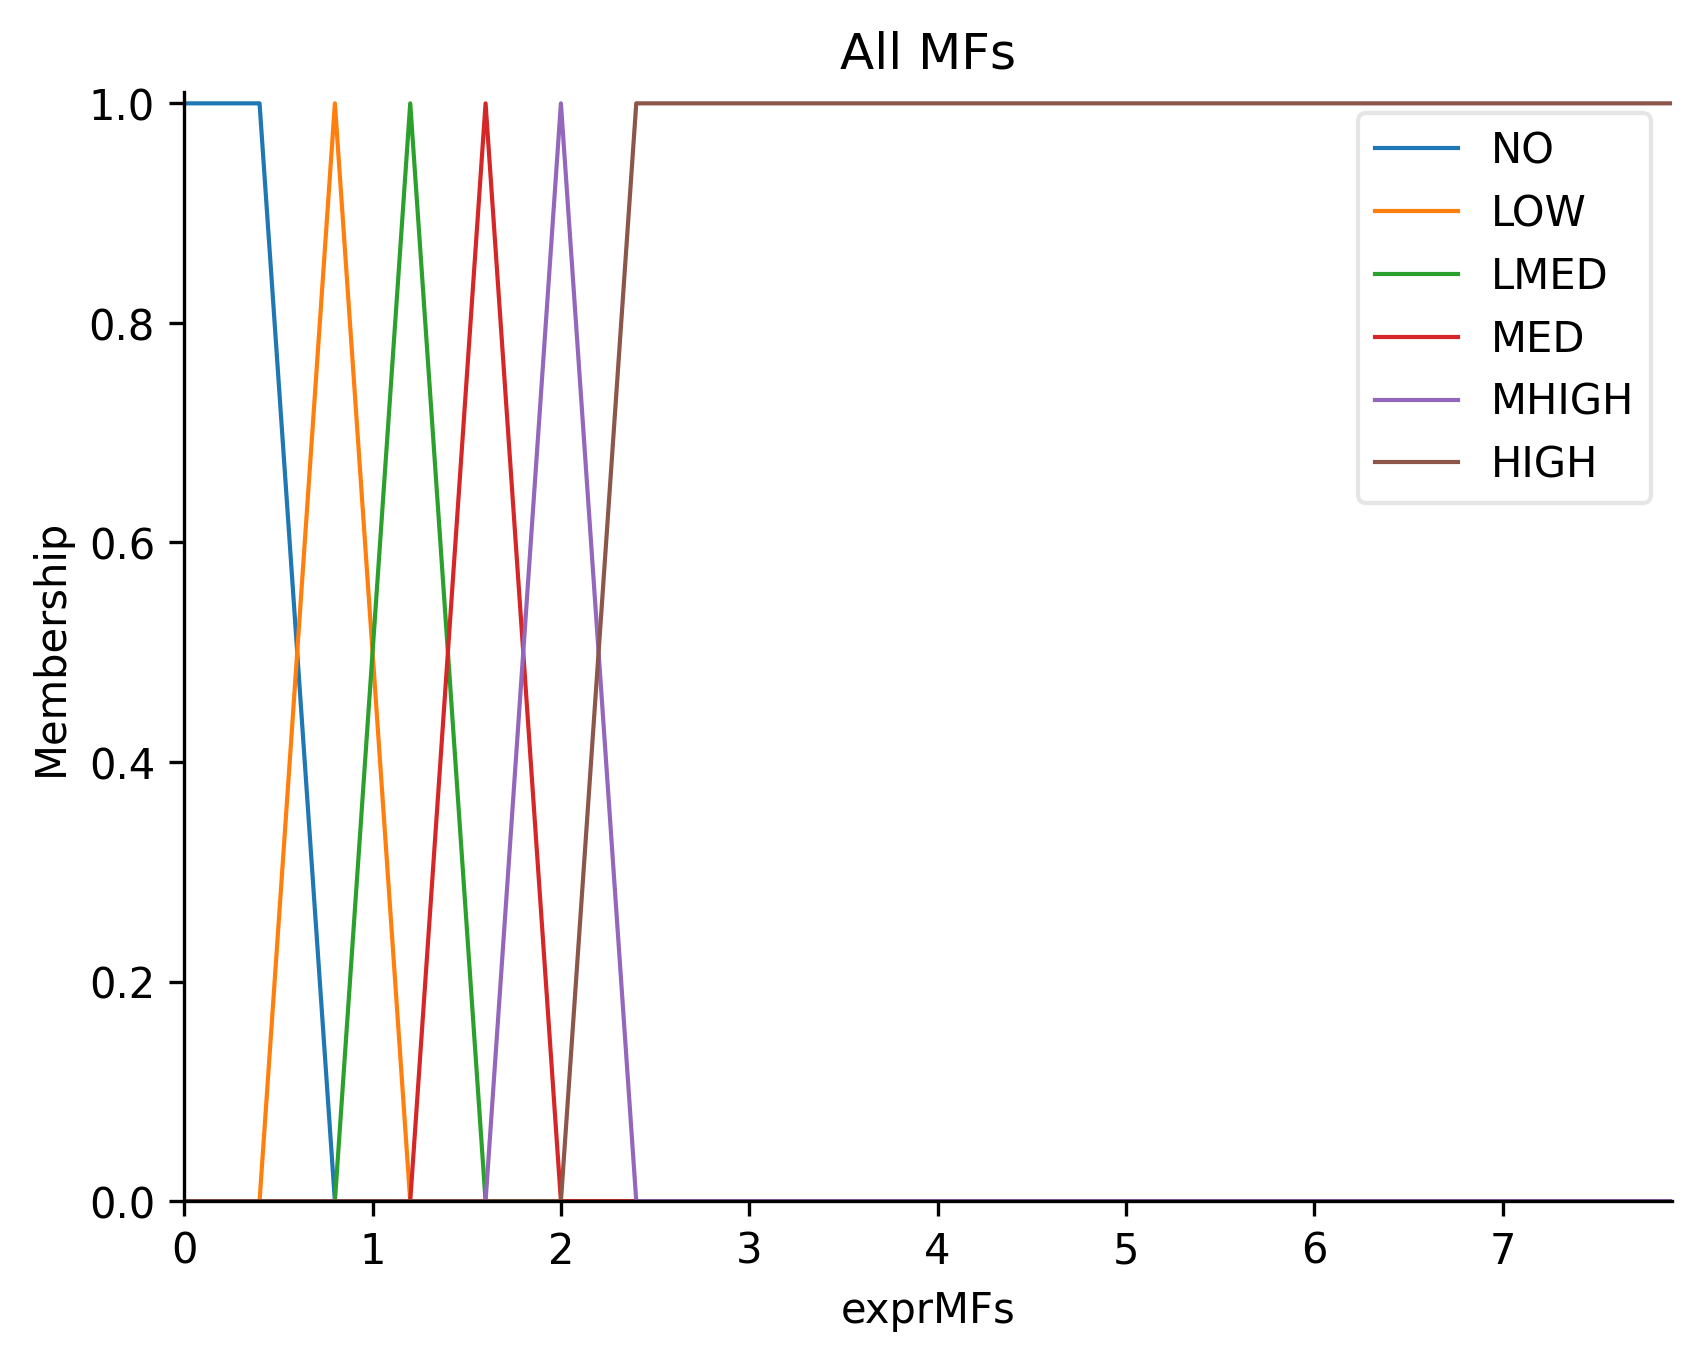

In [6]:
# Fuzzify the expression data using LegacyFuzzifier
# This transforms mean expression values into fuzzy membership scores for each state
explDFWide, mfFuzzy = LegacyFuzzifier.fuzzify(
    exprData, stepsize=0.1, 
    seriesOrder=["cluster.1","cluster.2","cluster.3"],
    mfLevels = ["NO","LOW","LMED","MED", "MHIGH", "HIGH"],
    centers=[0.4, 0.8, 1.2, 1.6, 2, 2.4]
)

In [7]:
# Define lists of interferon-stimulated genes (ISGs) for downstream analysis
isgListLong = sorted(set(["MX1","MX2","MT2A","RSAD2","SIGLEC1","IFIT1","IFI44","IFI27","IFITM10","IFIT3","IFI6","IFIT1P1","IFIT2","IFITM9P","IFI30","IFITM3","IFI44L","IFIT1B","IFITM5","IFITM3P2","IFITM3P9","IFI27L2","IFIT5","IFITM1","IFIH1","IFI16","IFI35","IFI27L1","IRF6","IRF7","IRF9","IRF5","IRF4","IRF2BP2","IRF2BPL","IRF3","IRF1-AS1","ISG15","ISG20L2","ISG20","XAF1","LY6E","IFITM2","IFITM3P6","IFITM3P3","IFIT6P","IRF2BP1","IRF5P1","IRF2","IRF1","IRF8","IFITM3P7","IFITM4P","IFITM3P1","IFITM3P8"]))
isgListShort = sorted(set(["MT2A", "ISG15", "LY6E", "IFIT1", "IFIT2", "IFIT3", "IFITM1", "IFITM3", "IFI44L", "IFI6", "MX1", "IFI27",  "IFI44L", "RSAD2", "SIGLEC1", "IFIT1"]))

In [8]:
# Create a FlowAnalysis object for the fuzzified data
# Map cluster timepoints to display names
fa = FlowAnalysis(
    explDFWide, "gene", 
    (  ("1", "TP 1"),("2", "TP 2"),("3", "TP 3")), 
    mfFuzzy, sep=".cluster."
)

In [9]:
# ...existing code...

In [10]:
# Create a color map for plotting flows by state
import seaborn as sns

scm = fa._create_series_color_map(None, "scaling")
icefires = sns.color_palette("icefire", len(scm)+2)

sc = {x: scm[x](1.0) for xi, x in enumerate(scm)}
# Alternative: assign colors from icefire palette
# sc = {x: icefires[xi+1] for xi, x in enumerate(scm)}
sc

{'TP 1': (np.float64(0.267004),
  np.float64(0.004874),
  np.float64(0.329415),
  np.float64(1.0)),
 'TP 2': (np.float64(0.190631),
  np.float64(0.407061),
  np.float64(0.556089),
  np.float64(1.0)),
 'TP 3': (np.float64(0.20803),
  np.float64(0.718701),
  np.float64(0.472873),
  np.float64(1.0))}

In [11]:
# ...existing code...

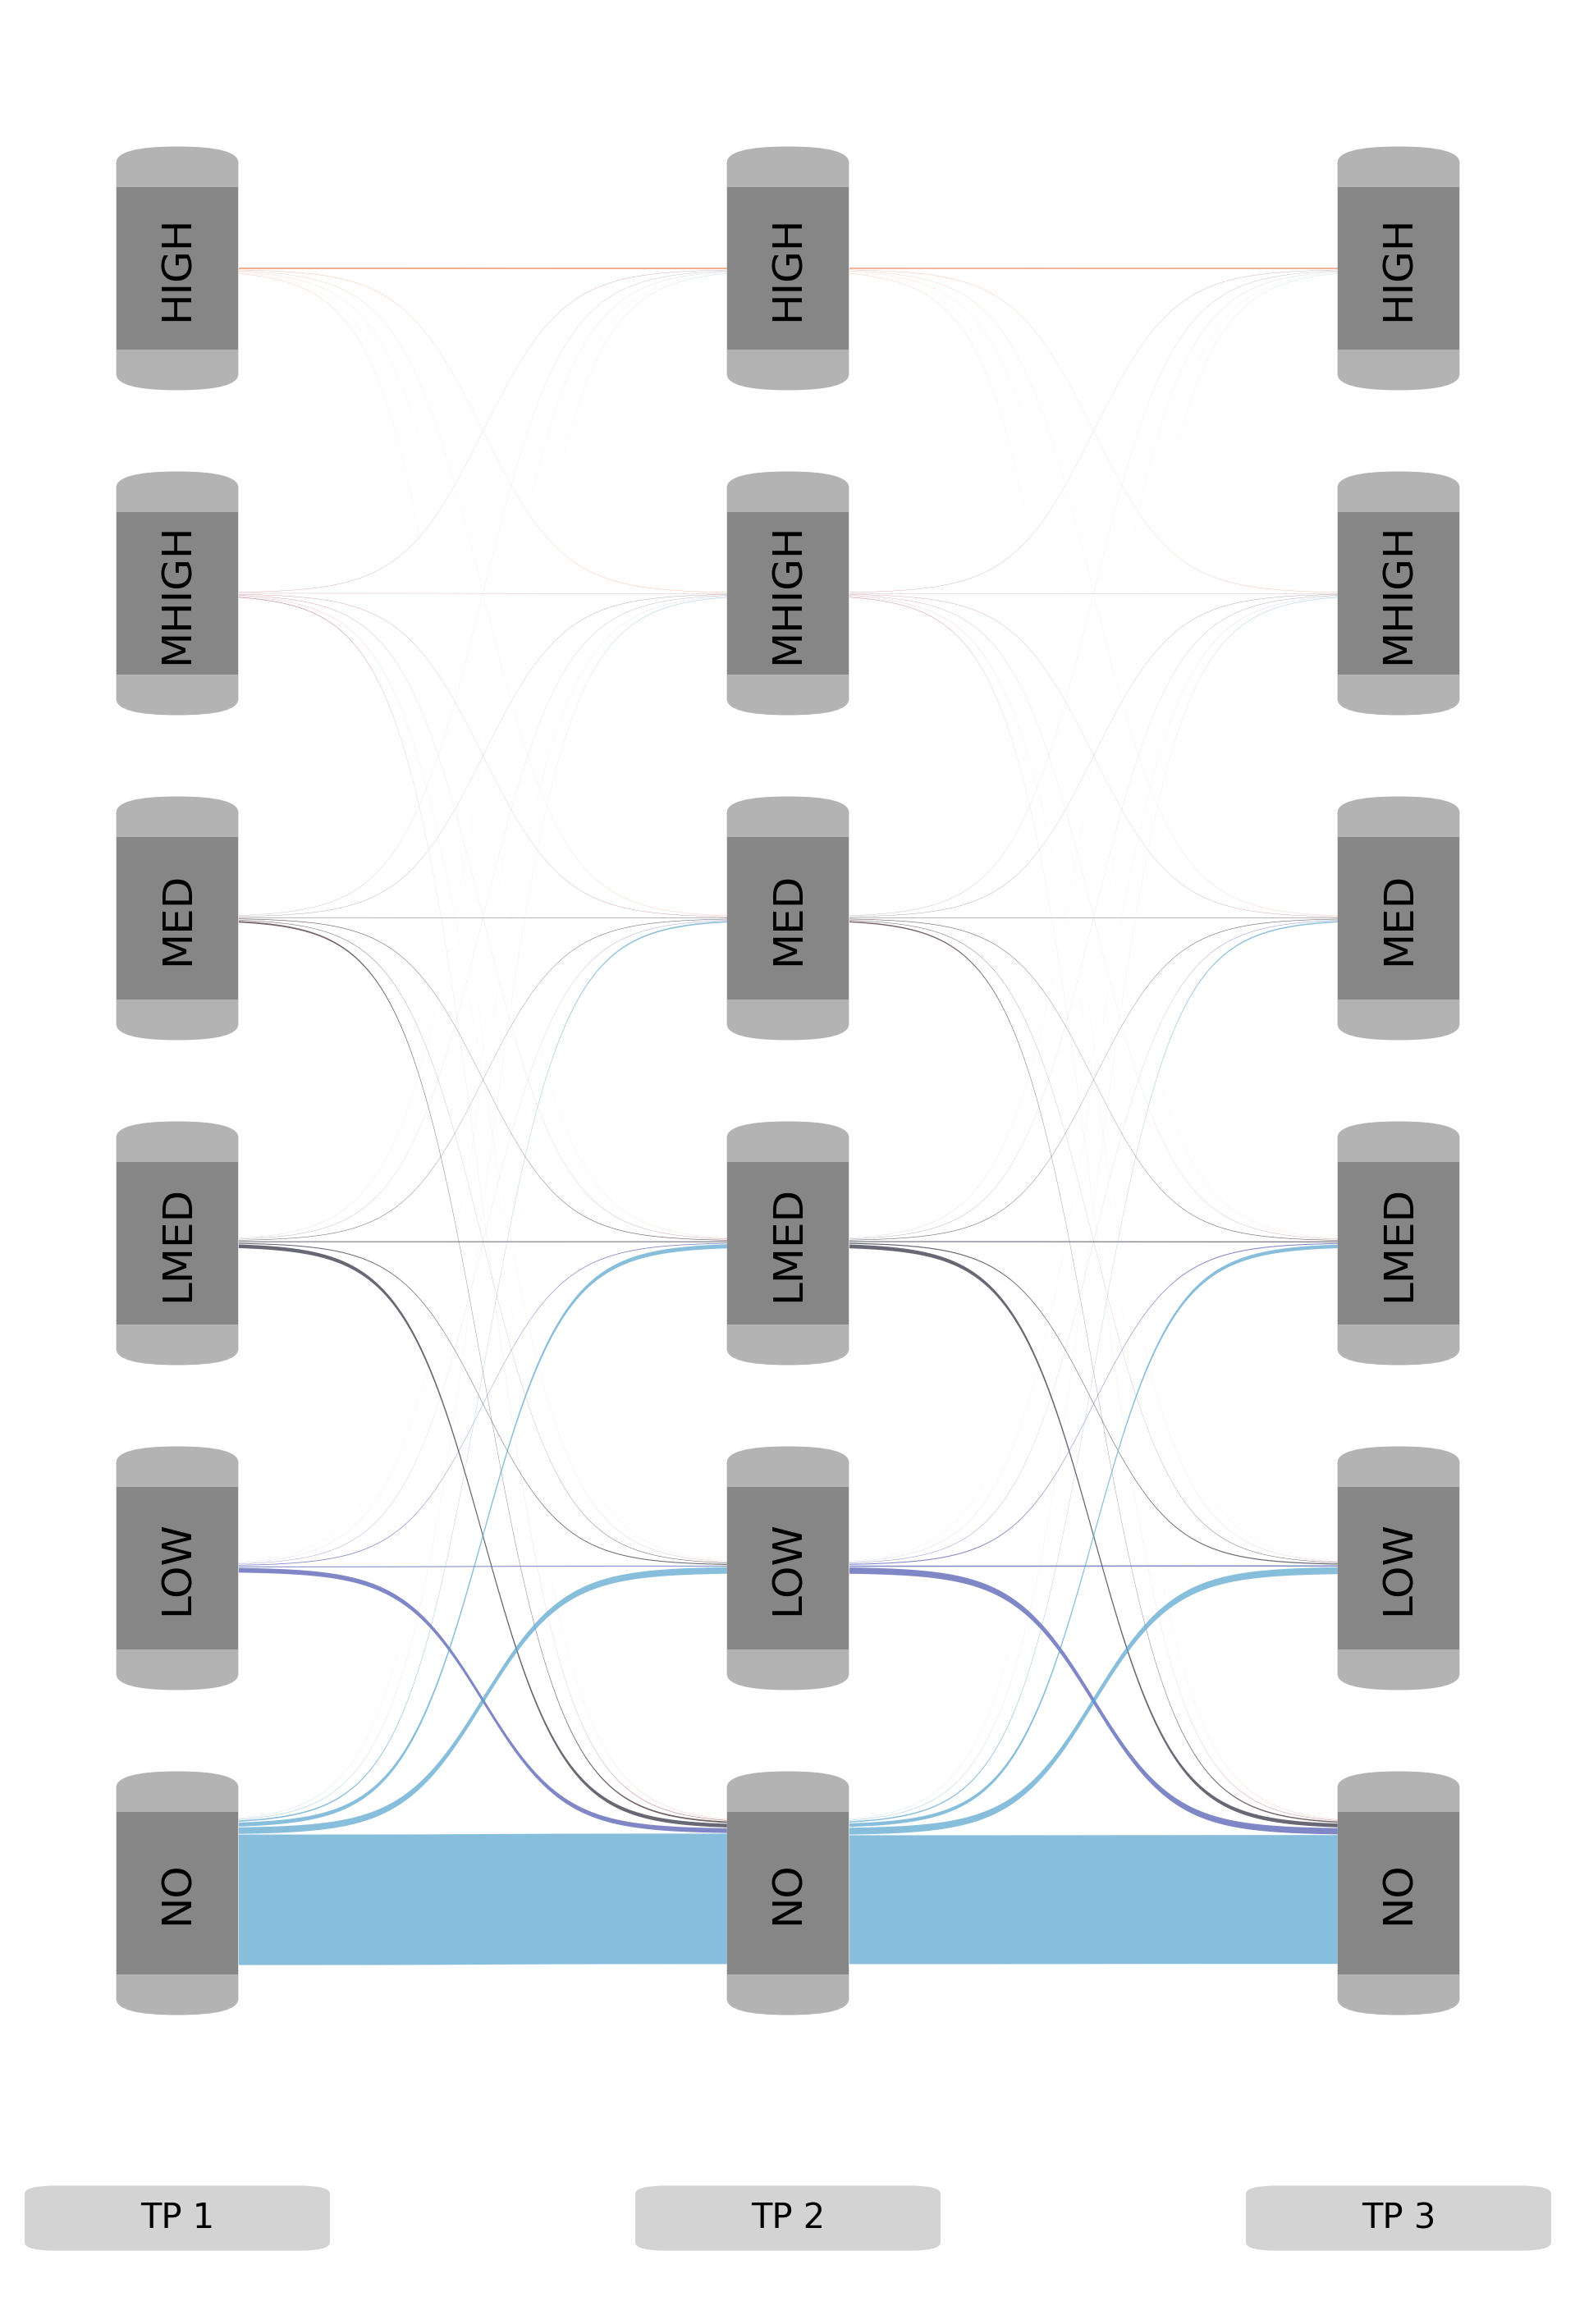

In [12]:
# Plot all flows with custom colors
fa.plot_flows(verbose=False,  figsize=(8,12))

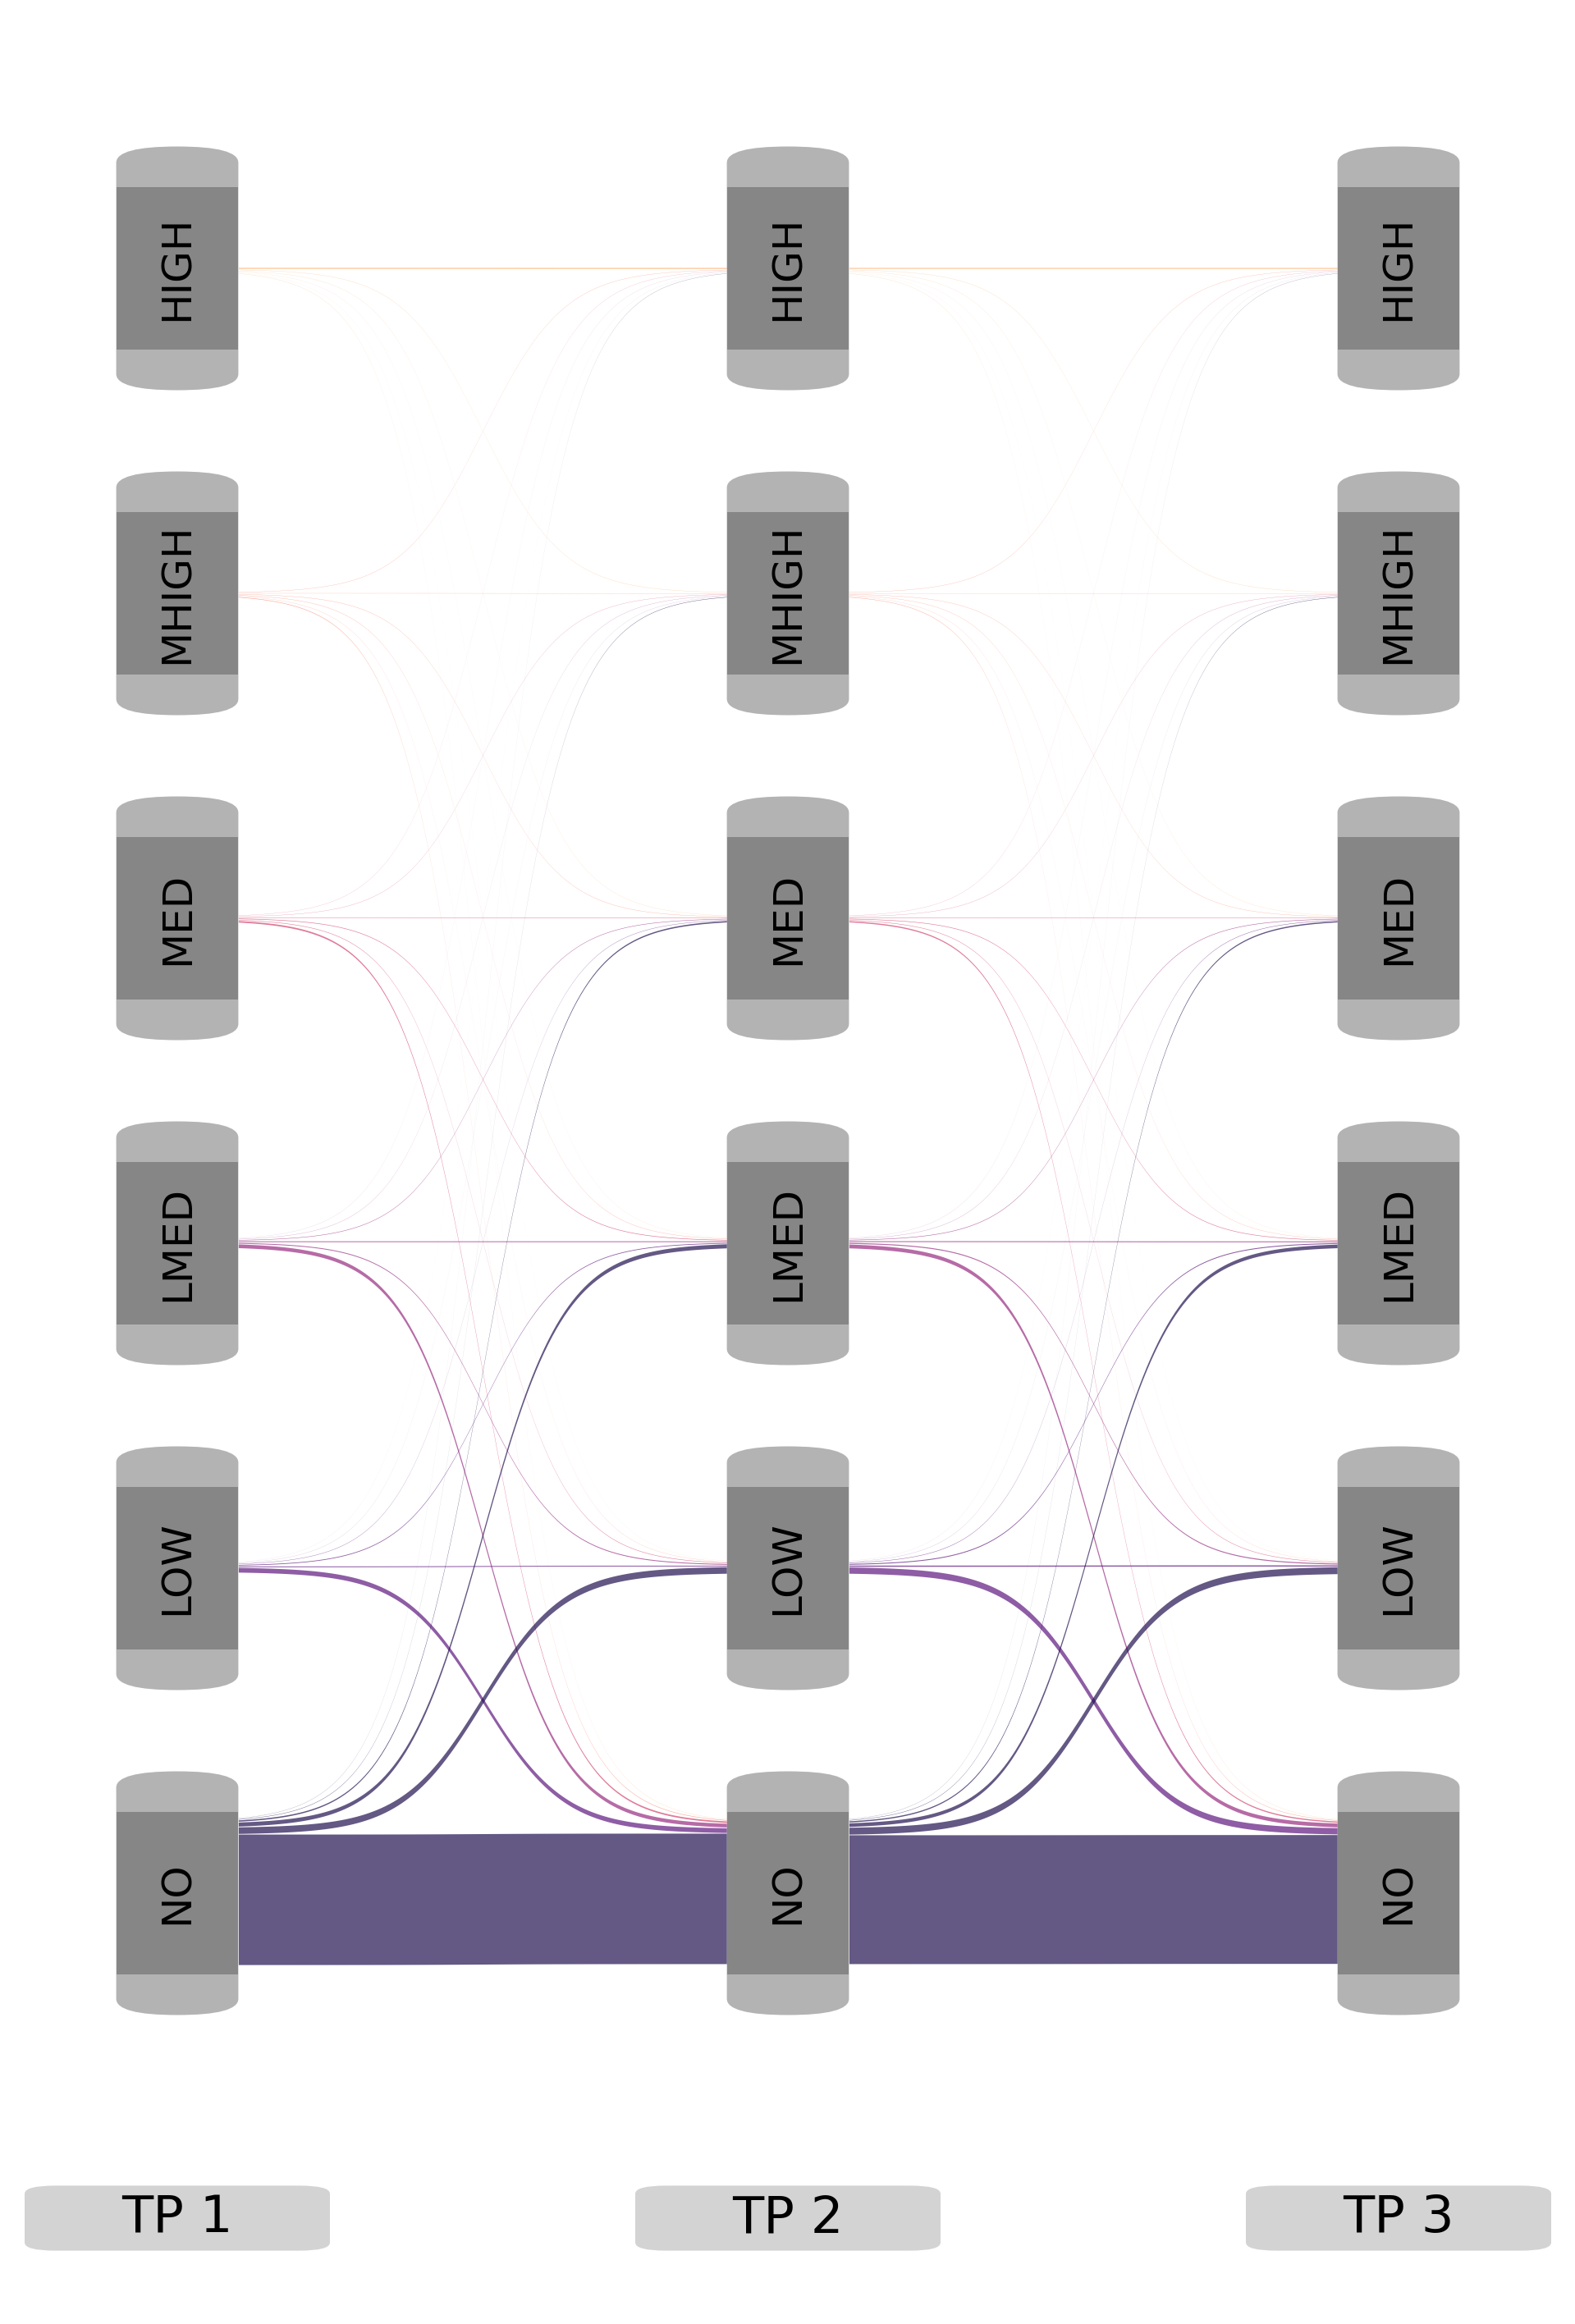

In [57]:
# Plot all flows and save to file
fa.plot_flows(outfile="plots/asympt_flows",sns_palette="magma",classFontsize=12,seriesFontsize=15, figsize=(8,12))

Creating FlowIDs
72 [('1', 'LMED'), ('2', 'NO'), ('3', 'NO')]
78 [('1', 'LMED'), ('2', 'LOW'), ('3', 'NO')]
79 [('1', 'LMED'), ('2', 'LOW'), ('3', 'LOW')]
108 [('1', 'MED'), ('2', 'NO'), ('3', 'NO')]
114 [('1', 'MED'), ('2', 'LOW'), ('3', 'NO')]
115 [('1', 'MED'), ('2', 'LOW'), ('3', 'LOW')]
120 [('1', 'MED'), ('2', 'LMED'), ('3', 'NO')]
121 [('1', 'MED'), ('2', 'LMED'), ('3', 'LOW')]
144 [('1', 'MHIGH'), ('2', 'NO'), ('3', 'NO')]
150 [('1', 'MHIGH'), ('2', 'LOW'), ('3', 'NO')]
151 [('1', 'MHIGH'), ('2', 'LOW'), ('3', 'LOW')]
156 [('1', 'MHIGH'), ('2', 'LMED'), ('3', 'NO')]
157 [('1', 'MHIGH'), ('2', 'LMED'), ('3', 'LOW')]
162 [('1', 'MHIGH'), ('2', 'MED'), ('3', 'NO')]
163 [('1', 'MHIGH'), ('2', 'MED'), ('3', 'LOW')]
180 [('1', 'HIGH'), ('2', 'NO'), ('3', 'NO')]
186 [('1', 'HIGH'), ('2', 'LOW'), ('3', 'NO')]
187 [('1', 'HIGH'), ('2', 'LOW'), ('3', 'LOW')]
192 [('1', 'HIGH'), ('2', 'LMED'), ('3', 'NO')]
193 [('1', 'HIGH'), ('2', 'LMED'), ('3', 'LOW')]
198 [('1', 'HIGH'), ('2', 'MED'), 

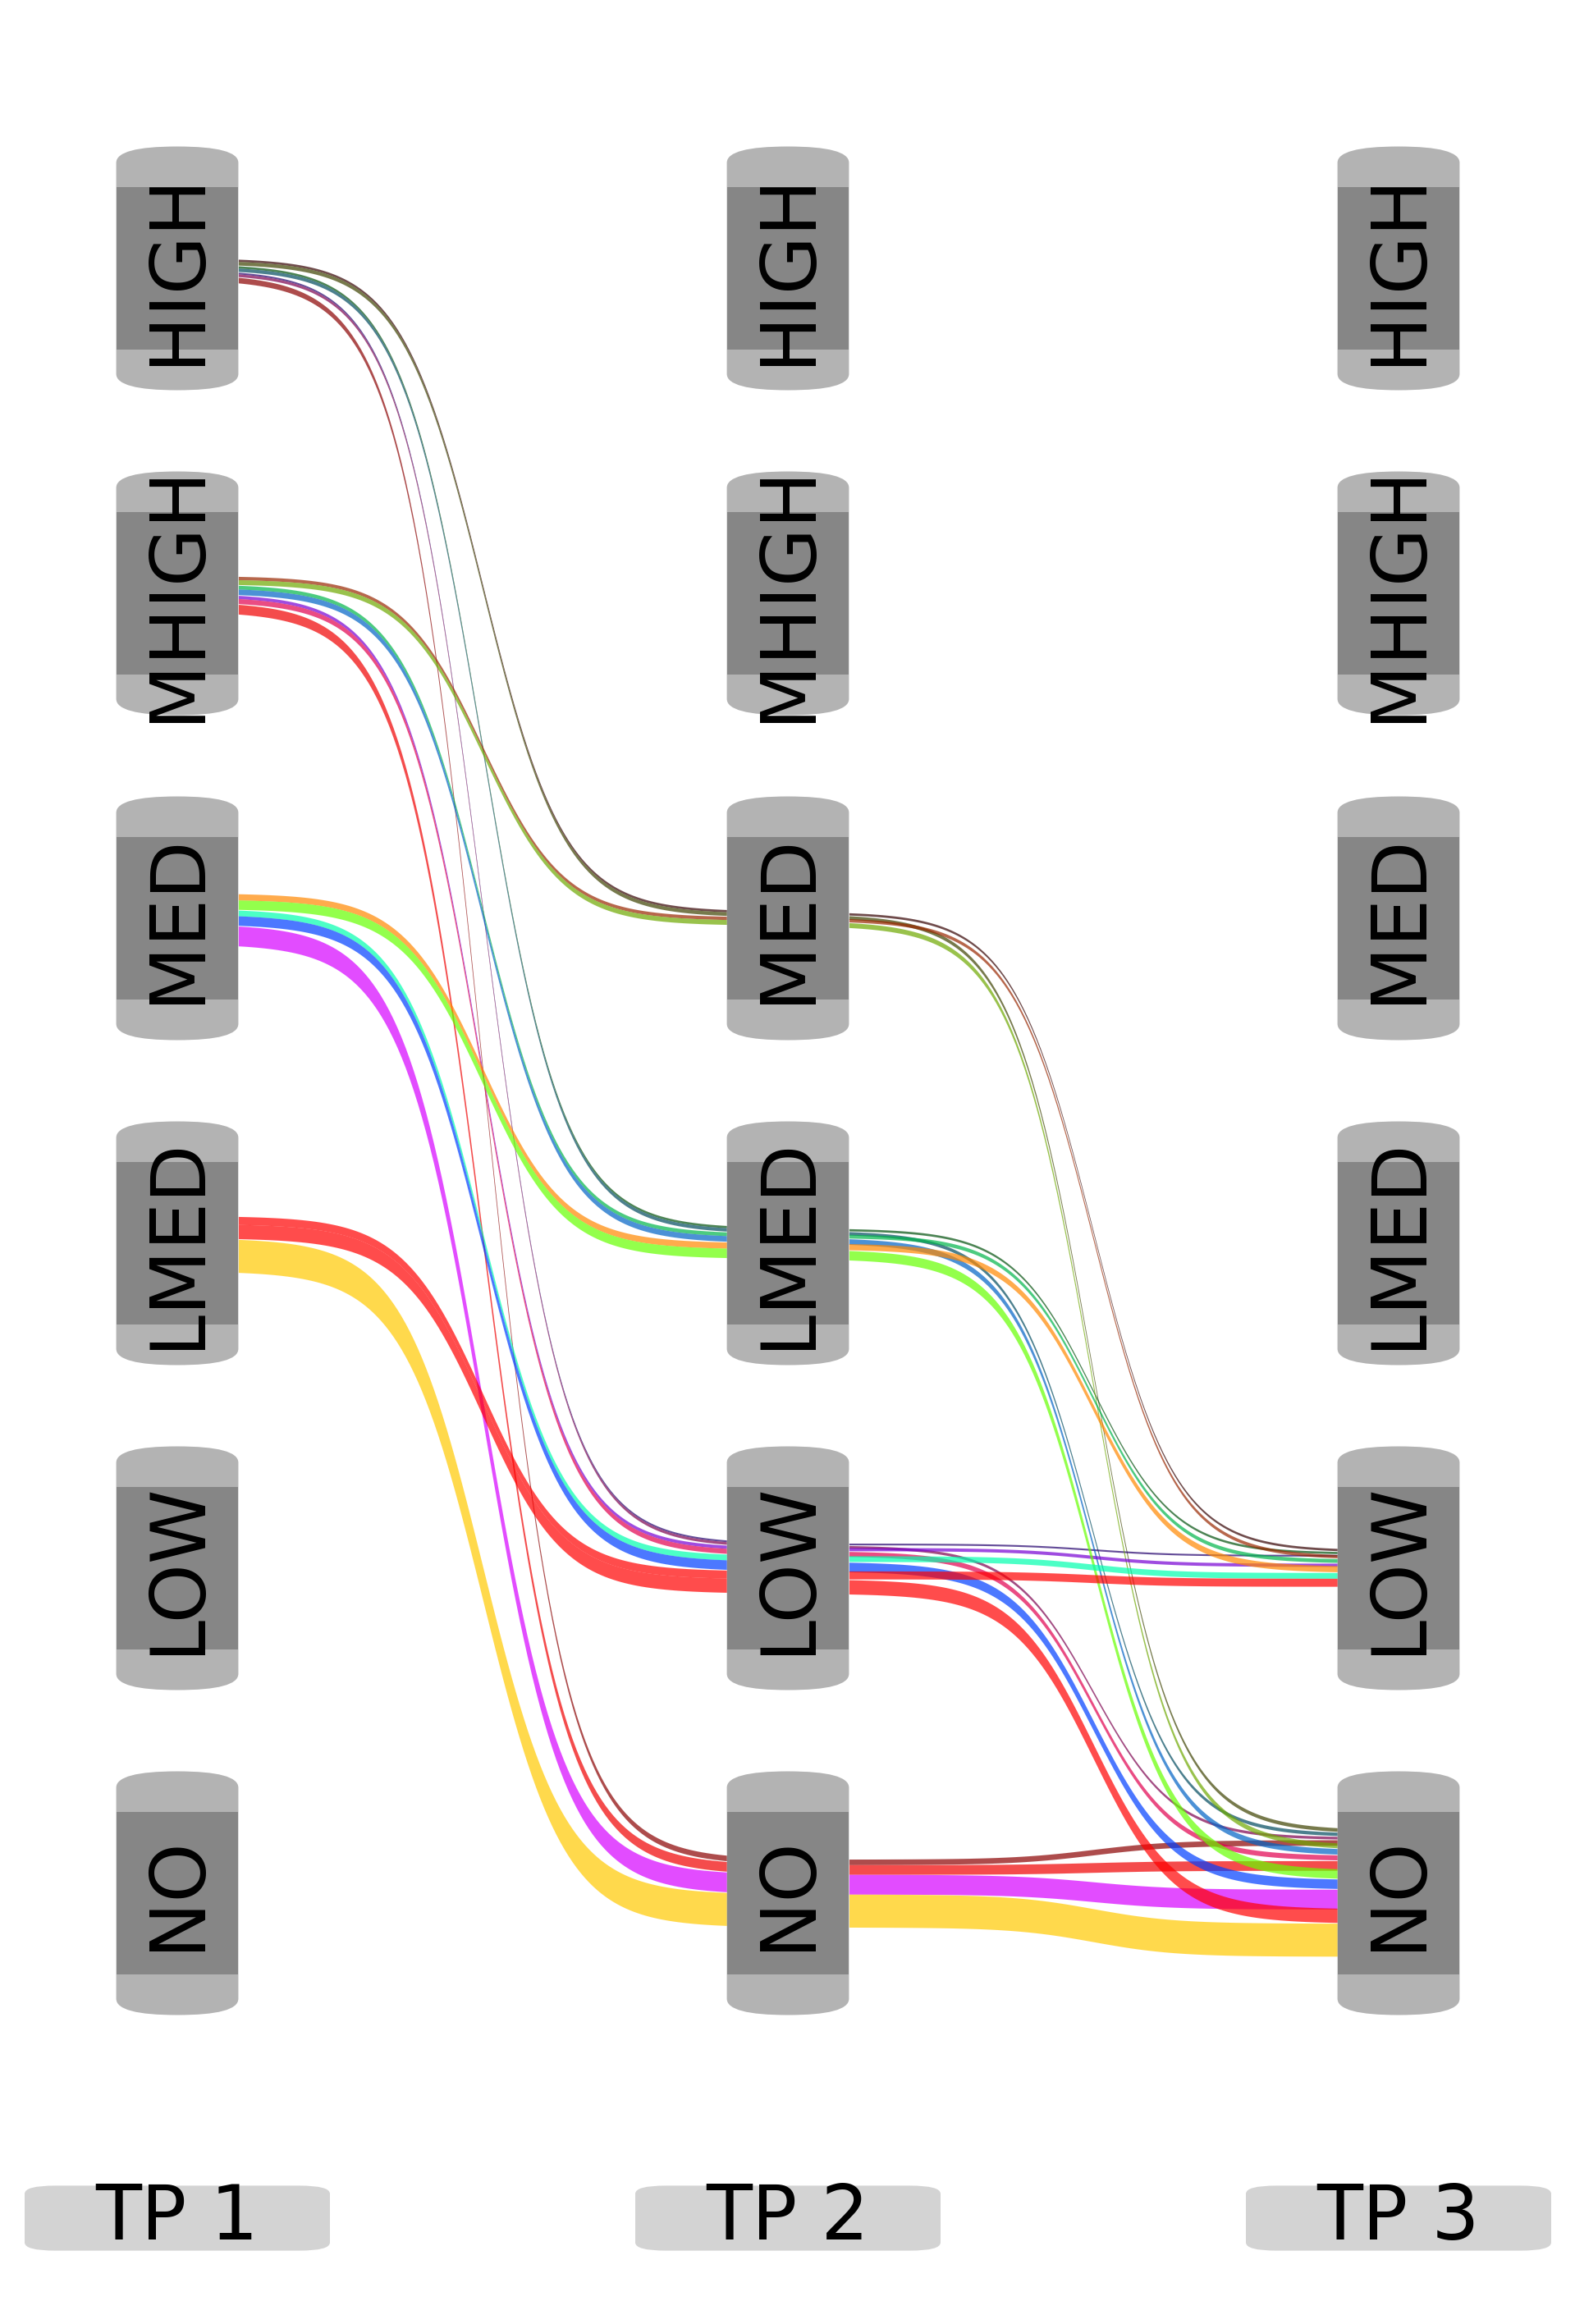

In [14]:
# Find relevant flow paths for genes with high expression in the first state
relFlows = fa.path_finder([">", ">="], minLevels=["LMED", None, None], maxLevels=["HIGH", "MED", "LOW"], verbose=True)

# Plot selected flow paths
fa.plot_paths(use_flows=relFlows,  figsize=(8,12), outfile="plots/asympt_selected_paths")

In [16]:
# Convert selected flow paths to edges for further analysis
relEdges = fa.paths2edges(relFlows)

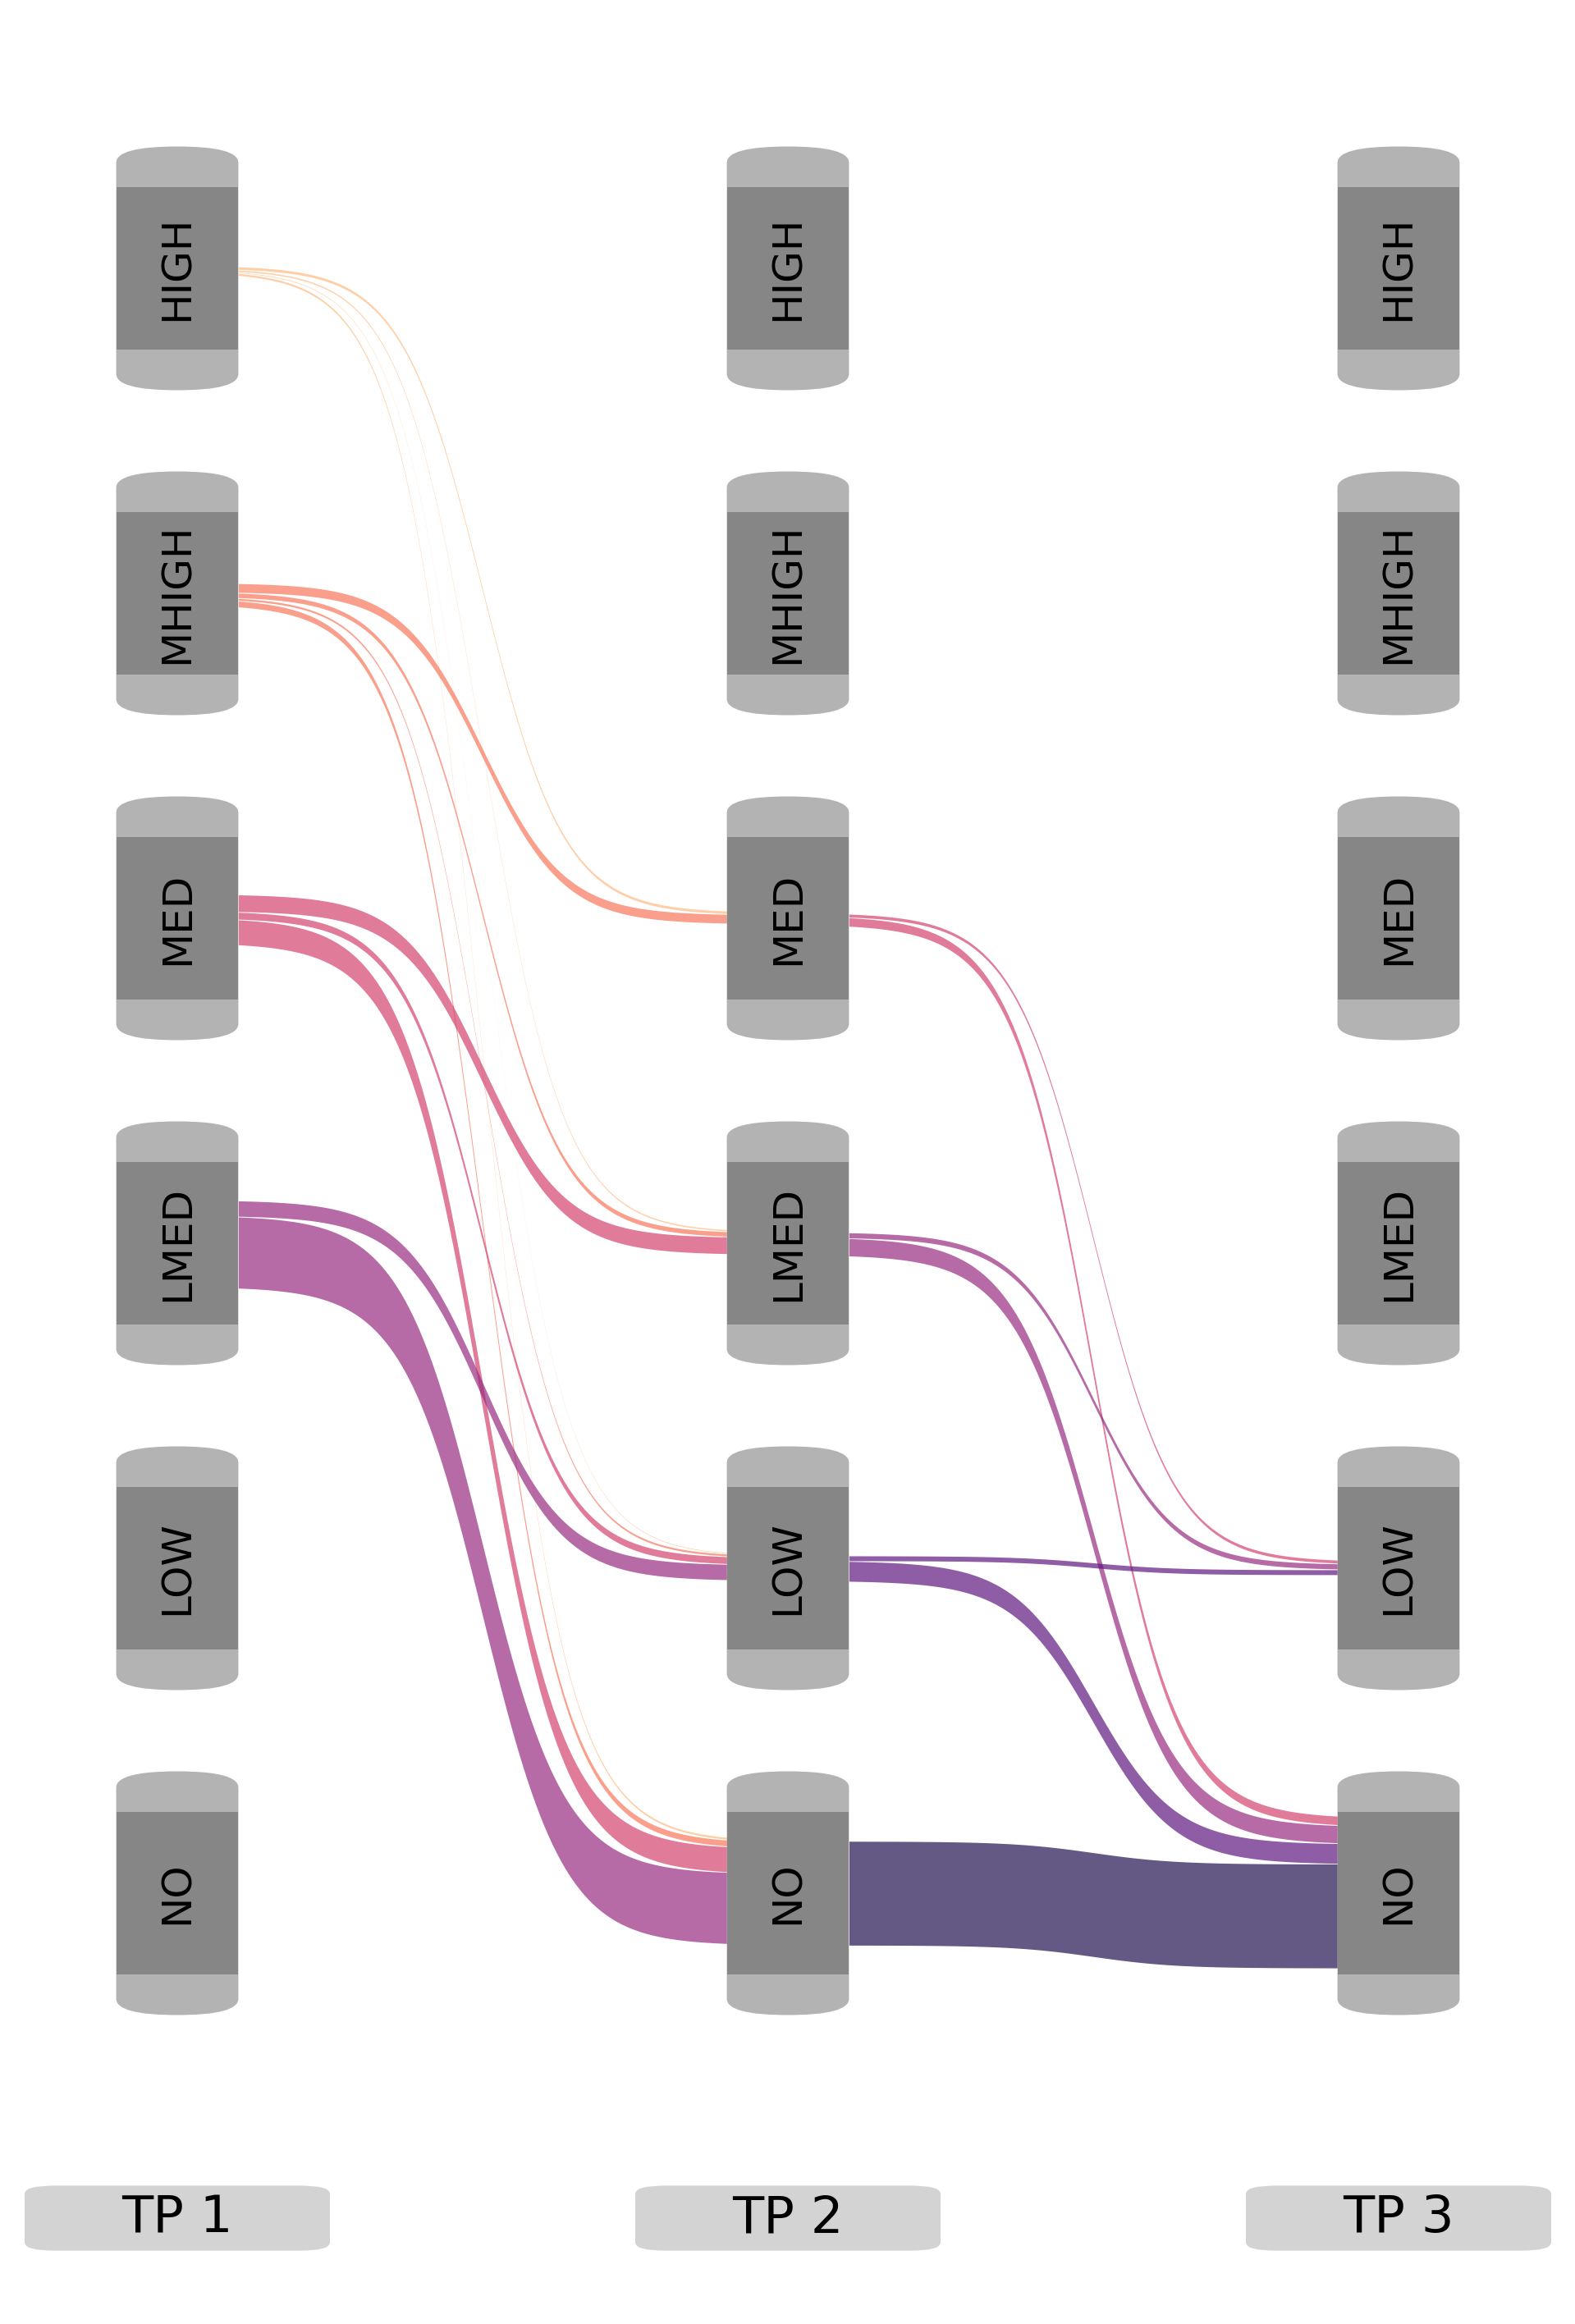

In [56]:
# Plot flows for selected edges
fa.plot_flows(relEdges, figsize=(8,12),sns_palette="magma",classFontsize=12,seriesFontsize=15, outfile="plots/asympt_selected_edges")

In [21]:
# ...existing code...

In [22]:
# Pathway analysis for selected edges using ISG gene sets
pwScoresGrp = fa.analyse_pathways(additional_genesets=[("ISG_SHORT", isgListShort), ("ISG_LONG", isgListLong)], use_edges=relEdges)
pwScoresGrp

Loading pathways from ReactomePathways.gmt
Identified 2612 pathways


Calculating p-values for groups [1, 2, 3, 4, 10, 50, 100, np.int64(2605)]


pwid                                             pwname  \
14     R-HSA-112122      ALKBH2 mediated reversal of alkylation damage   
17    R-HSA-5467333  APC truncation mutants are not K63 polyubiquit...   
30    R-HSA-9717264                     ASP-3026-resistant ALK mutants   
46    R-HSA-2978092  Abnormal conversion of 2-oxoglutarate to 2-hyd...   
160    R-HSA-211957  Aromatic amines can be N-hydroxylated or N-dea...   
...             ...                                                ...   
2566    R-HSA-72172                                      mRNA Splicing   
2567    R-HSA-72163                      mRNA Splicing - Major Pathway   
2592    R-HSA-72312                                    rRNA processing   
2594  R-HSA-8868773         rRNA processing in the nucleus and cytosol   
2603    R-HSA-72306                                    tRNA processing   

         pwFlow  pwGenes  allPwFlow   allPwGenes  pw_gene_intersection  \
14     0.007576        1  553.08789  7670.000132                     1   
17     0.061993        1  553.08789  7670.000132                     1   
30     0.000000        1  553.08789  7670.000132                     0   
46     0.027298        1  553.08789  7670.000132                     1   
160    0.000000        1  553.08789  7670.000132                     0   
...         ...      ...        ...          ...                   ...   
2566  16.932267      215  553.08789  7670.000132                   209   
2567  16.620236      204  553.08789  7670.000132                   201   
2592   6.013929      237  553.08789  7670.000132                   210   
2594   5.765255      199  553.08789  7670.000132                   188   
2603   3.624845      146  553.08789  7670.000132                   119   

      pw_coverage  genes_coverage  mean_coverage  pw_coverage_zscore  \
14       0.007576        0.000014   1.037689e-07           -0.777275   
17       0.061993        0.000112   6.948415e-06            0.477429   
30       0.000000        0.000000   0.000000e+00           -0.951954   
46       0.027298        0.000049   1.347295e-06           -0.322539   
160      0.000000        0.000000   0.000000e+00           -0.951954   
...           ...             ...            ...                 ...   
2566     0.078755        0.030614   2.411002e-03            1.949682   
2567     0.081472        0.030050   2.448218e-03            2.099979   
2592     0.025375        0.010873   2.759143e-04           -1.003105   
2594     0.028971        0.010424   3.019881e-04           -0.804191   
2603     0.024828        0.006554   1.627166e-04           -1.033392   

      pw_coverage_pval  pw_coverage_adj_pval  
14            1.000000              1.000000  
17            0.316528              1.000000  
30            1.000000              1.000000  
46            1.000000              1.000000  
160           1.000000              1.000000  
...                ...                   ...  
2566          0.025607              0.890929  
2567          0.017865              0.849092  
2592          1.000000              1.000000  
2594          1.000000              1.000000  
2603          1.000000              1.000000  

[2614 rows x 13 columns]

pwid                                             pwname  \
2612      ISG_SHORT                                          ISG_SHORT   
418   R-HSA-3134963  DEx/H-box helicases activate type I IFN and in...   
1876  R-HSA-9707587        Regulation of HMOX1 expression and activity   
2289  R-HSA-6791055  TALDO1 deficiency: failed conversion of SH7P, ...   
2288  R-HSA-6791462  TALDO1 deficiency: failed conversion of  Fru(6...   
848   R-HSA-2644605                 FBXW7 Mutants and NOTCH1 in Cancer   
1257  R-HSA-2644607  Loss of Function of FBXW7 in Cancer and NOTCH1...   
105    R-HSA-114294  Activation, translocation and oligomerization ...   
899    R-HSA-163210          Formation of ATP by chemiosmotic coupling   
2040  R-HSA-3065676               SUMO is conjugated to E1 (UBA2:SAE1)   
397   R-HSA-1236978  Cross-presentation of soluble exogenous antige...   
468   R-HSA-9734195            Defective APRT disrupts adenine salvage   
2613       ISG_LONG                                           ISG_LONG   
1880   R-HSA-877312                       Regulation of IFNG signaling   
1910   R-HSA-211733  Regulation of activated PAK-2p34 by proteasome...   
1963   R-HSA-611105                     Respiratory electron transport   
1964   R-HSA-163200  Respiratory electron transport, ATP synthesis ...   
2359   R-HSA-844615                              The AIM2 inflammasome   
1191  R-HSA-1059683                            Interleukin-6 signaling   
2020    R-HSA-77588  SLBP Dependent Processing of Replication-Depen...   

         pwFlow  pwGenes  allPwFlow   allPwGenes  pw_gene_intersection  \
2612   4.343160       14  553.08789  7670.000132                    14   
418    1.128874        7  553.08789  7670.000132                     7   
1876   0.695252        5  553.08789  7670.000132                     5   
2289   0.193909        1  553.08789  7670.000132                     1   
2288   0.193909        1  553.08789  7670.000132                     1   
848    0.676728        5  553.08789  7670.000132                     5   
1257   0.676728        5  553.08789  7670.000132                     5   
105    0.370056        2  553.08789  7670.000132                     2   
899    2.007597       18  553.08789  7670.000132                    18   
2040   0.636568        5  553.08789  7670.000132                     5   
397    5.579106       50  553.08789  7670.000132                    45   
468    0.171017        1  553.08789  7670.000132                     1   
2613   7.783241       55  553.08789  7670.000132                    40   
1880   1.576987       14  553.08789  7670.000132                    14   
1910   5.623922       50  553.08789  7670.000132                    48   
1963   9.904586      103  553.08789  7670.000132                   103   
1964  12.152648      127  553.08789  7670.000132                   124   
2359   0.432578        3  553.08789  7670.000132                     3   
1191   1.158844       11  553.08789  7670.000132                    11   
2020   1.157136       11  553.08789  7670.000132                    11   

      pw_coverage  genes_coverage  mean_coverage  pw_coverage_zscore  \
2612     0.310226        0.007853       0.002436           11.441383   
418      0.161268        0.002041       0.000329            4.229338   
1876     0.139050        0.001257       0.000175            3.461963   
2289     0.193909        0.000351       0.000068            3.519068   
2288     0.193909        0.000351       0.000068            3.519068   
848      0.135346        0.001224       0.000166            3.334004   
1257     0.135346        0.001224       0.000166            3.334004   
105      0.185028        0.000669       0.000124            3.251780   
899      0.111533        0.003630       0.000405            2.988251   
2040     0.127314        0.001151       0.000147            3.056586   
397      0.111582        0.010087       0.001126            2.990333   
468      0.171017        0.000309       0

Index(['pwid', 'pwname', 'pwFlow', 'pwGenes', 'allPwFlow', 'allPwGenes',
       'pw_gene_intersection', 'pw_coverage', 'genes_coverage',
       'mean_coverage', 'pw_coverage_zscore', 'pw_coverage_pval',
       'pw_coverage_adj_pval'],
      dtype='object')
False
False
(10, 14)


/home/o/offensperger/.local/lib/python3.12/site-packages/flowsets/flowsets.py:3058: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


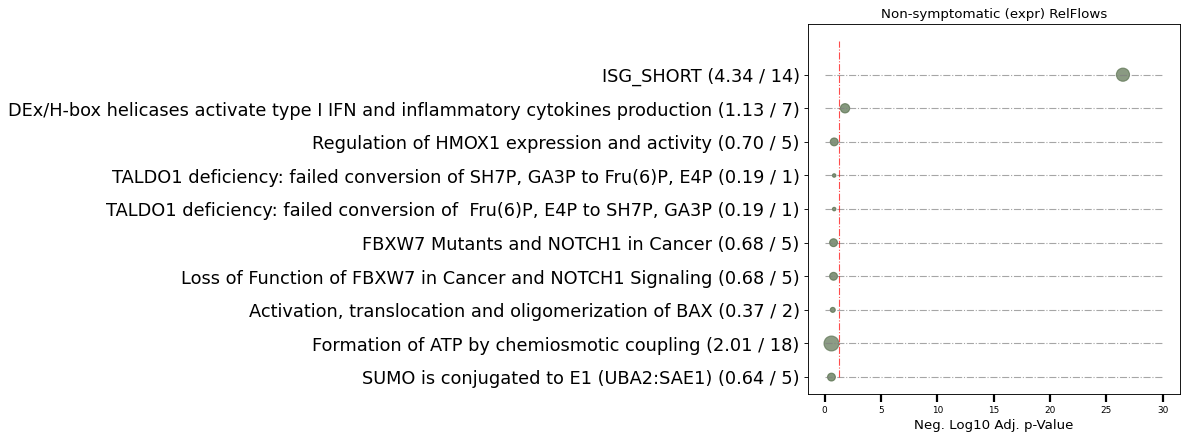

In [23]:
# Select and plot top pathways for non-symptomatic group
selPWsGrp = pwScoresGrp[(pwScoresGrp["pw_coverage_adj_pval"] < 1)].sort_values("pw_coverage_adj_pval", ascending=True).head(20)
display(selPWsGrp)
fa.plotORAresult(selPWsGrp, "Non-symptomatic (expr) RelFlows", numResults=10, figsize=(6,6), outfile="plots/asympt_ra")

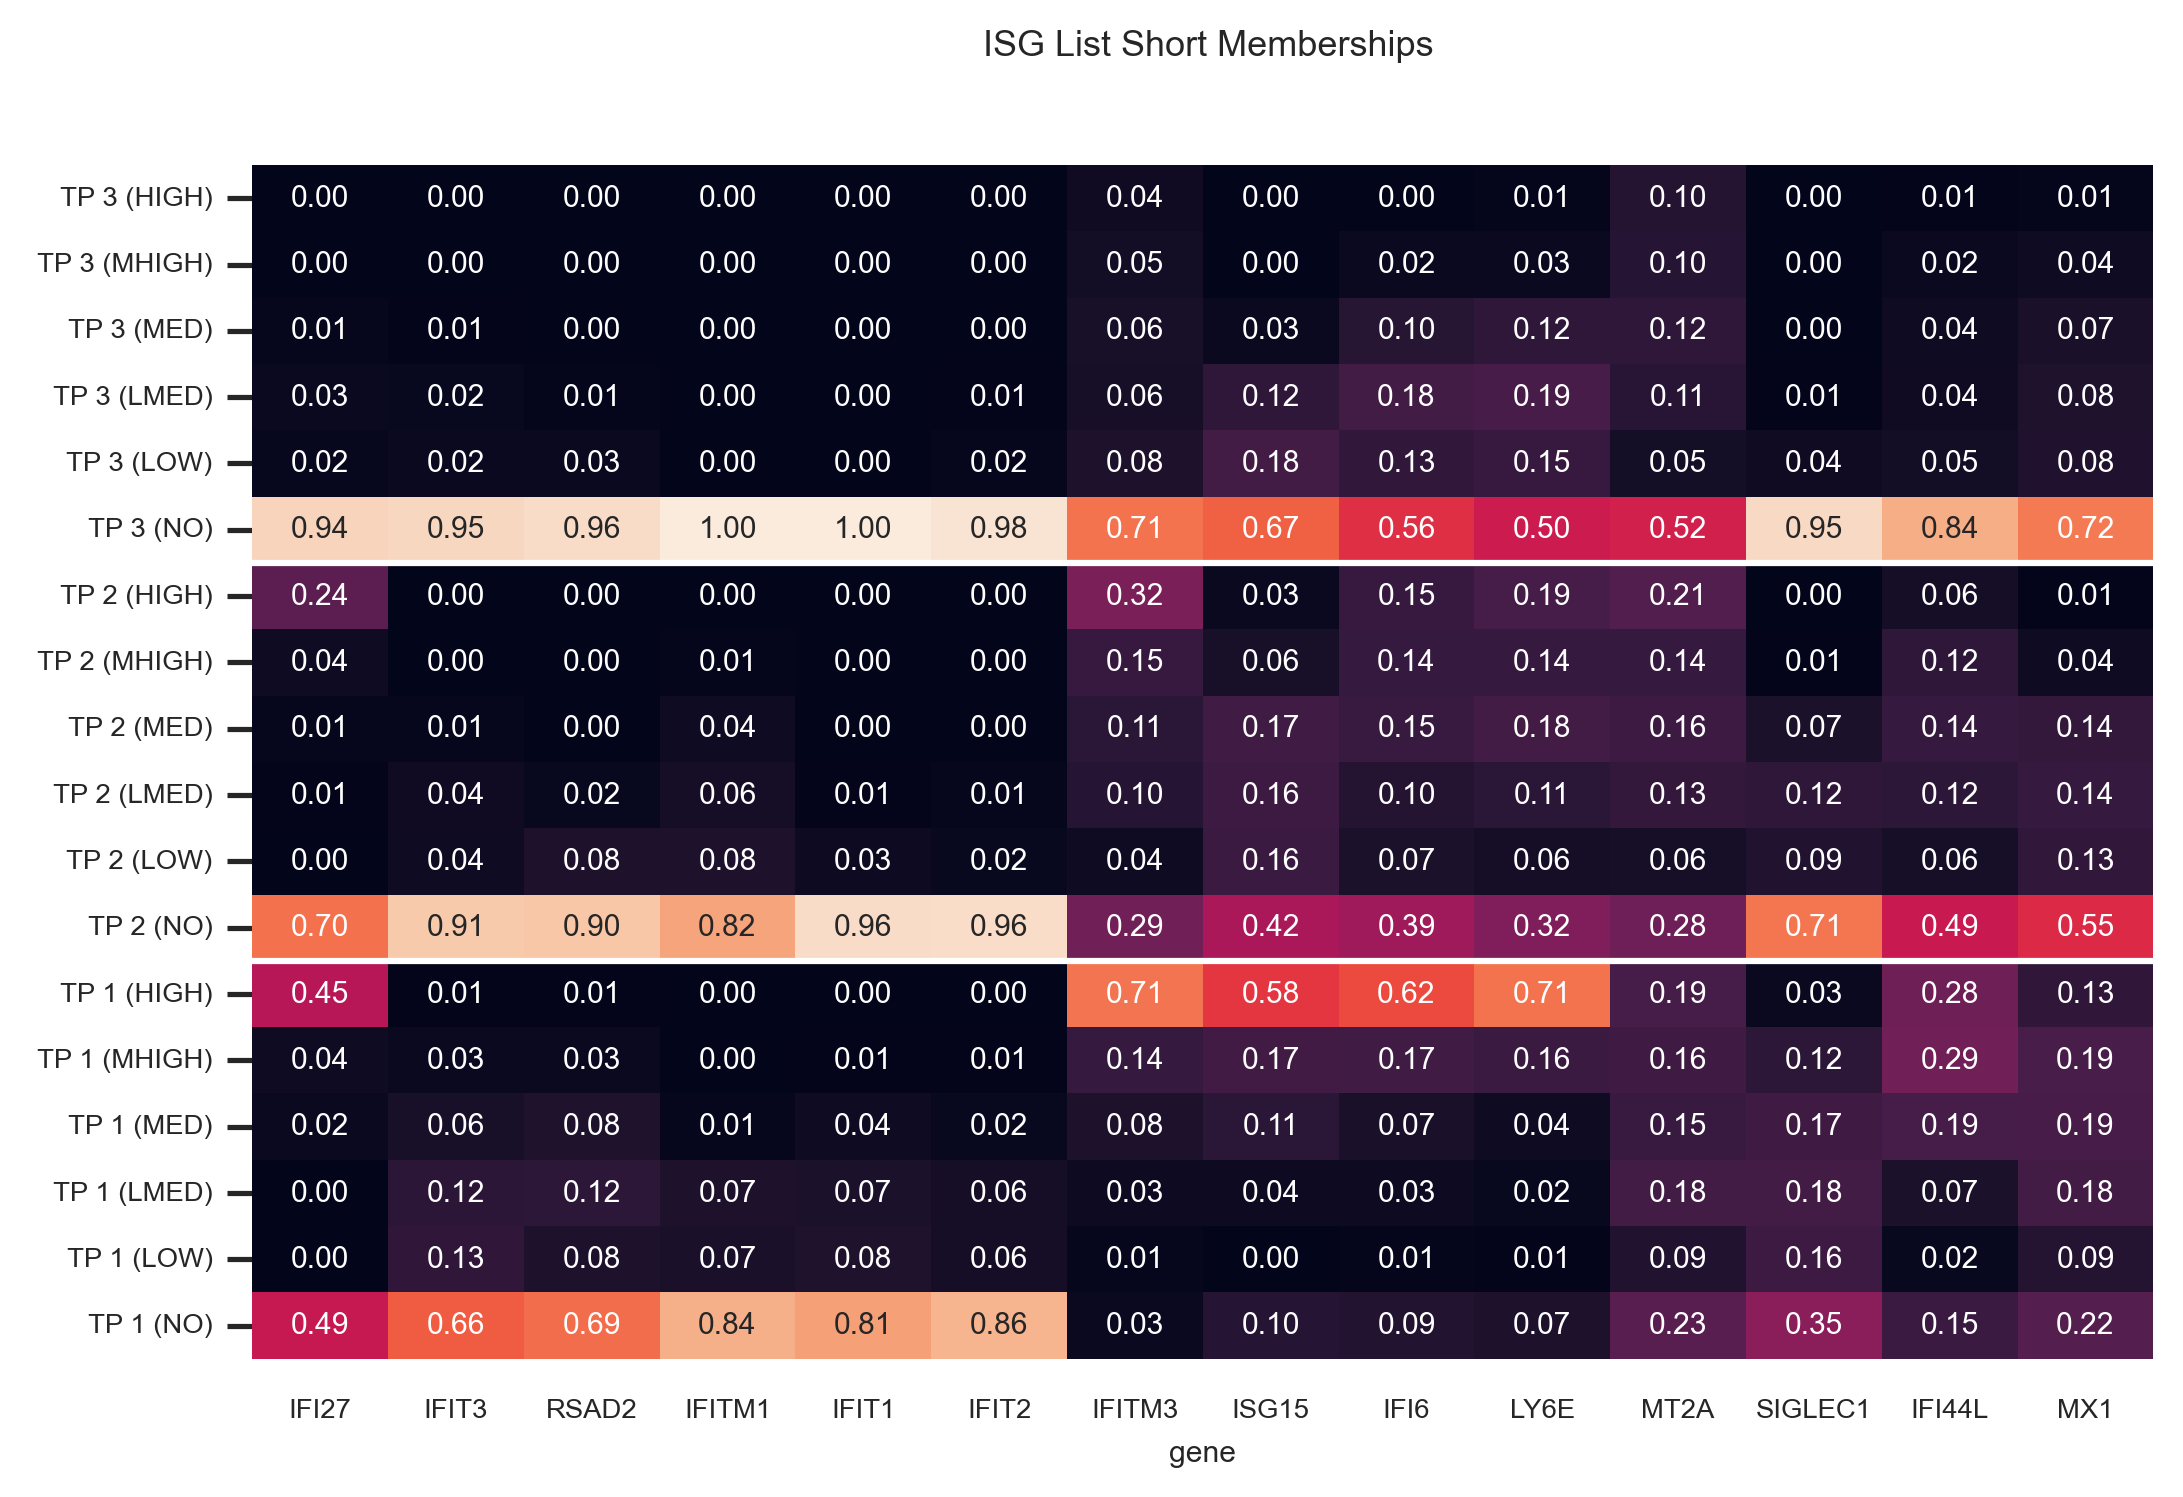

In [24]:
# Plot state memberships for the short ISG list
_ = fa.plot_state_memberships(genes=isgListShort, name="ISG List Short Memberships", cluster_genes=True, outfile="plots/asympt_memberships",prefix="", font_scale=0.6, figsize=(8,5))

Found 12 of 55 (query) in 25 (top) genes.


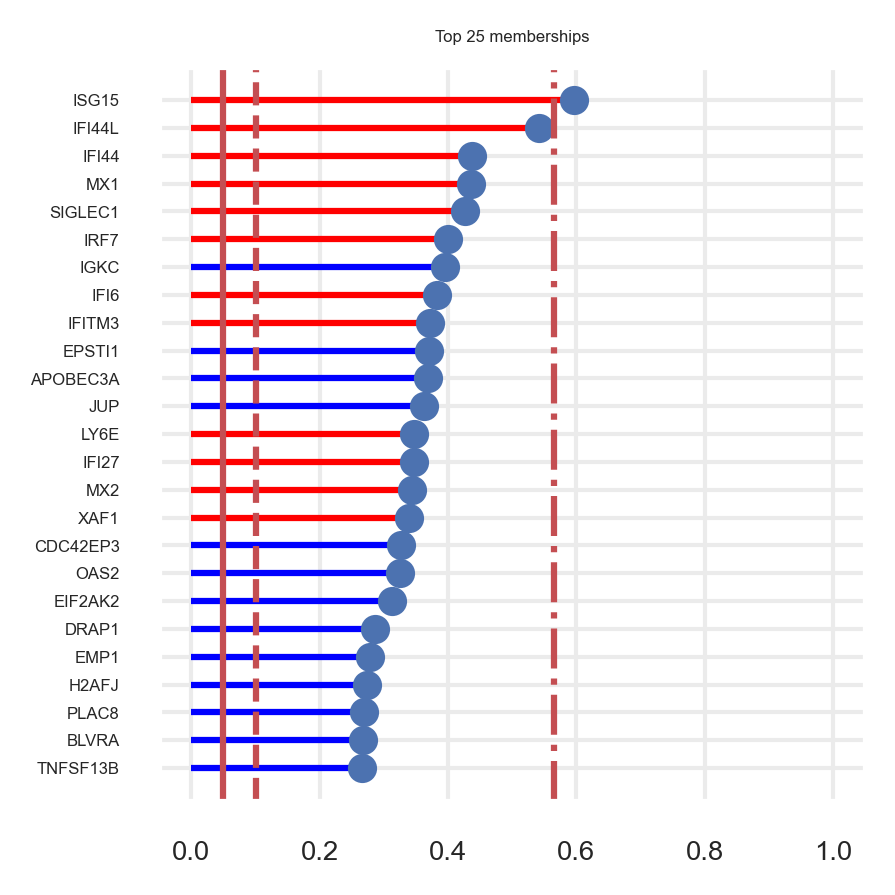

In [25]:
# Plot flow memberships for selected edges, highlighting ISG genes
_ = fa.plot_flow_memberships(use_edges=relEdges, outfile="plots/asympt_flow_memberships", n_genes=25, gene_exclude_patterns=["AC", "AF", "AL", "LINC"], color_genes=isgListLong,figsize=(3,3), plot_histogram=False)

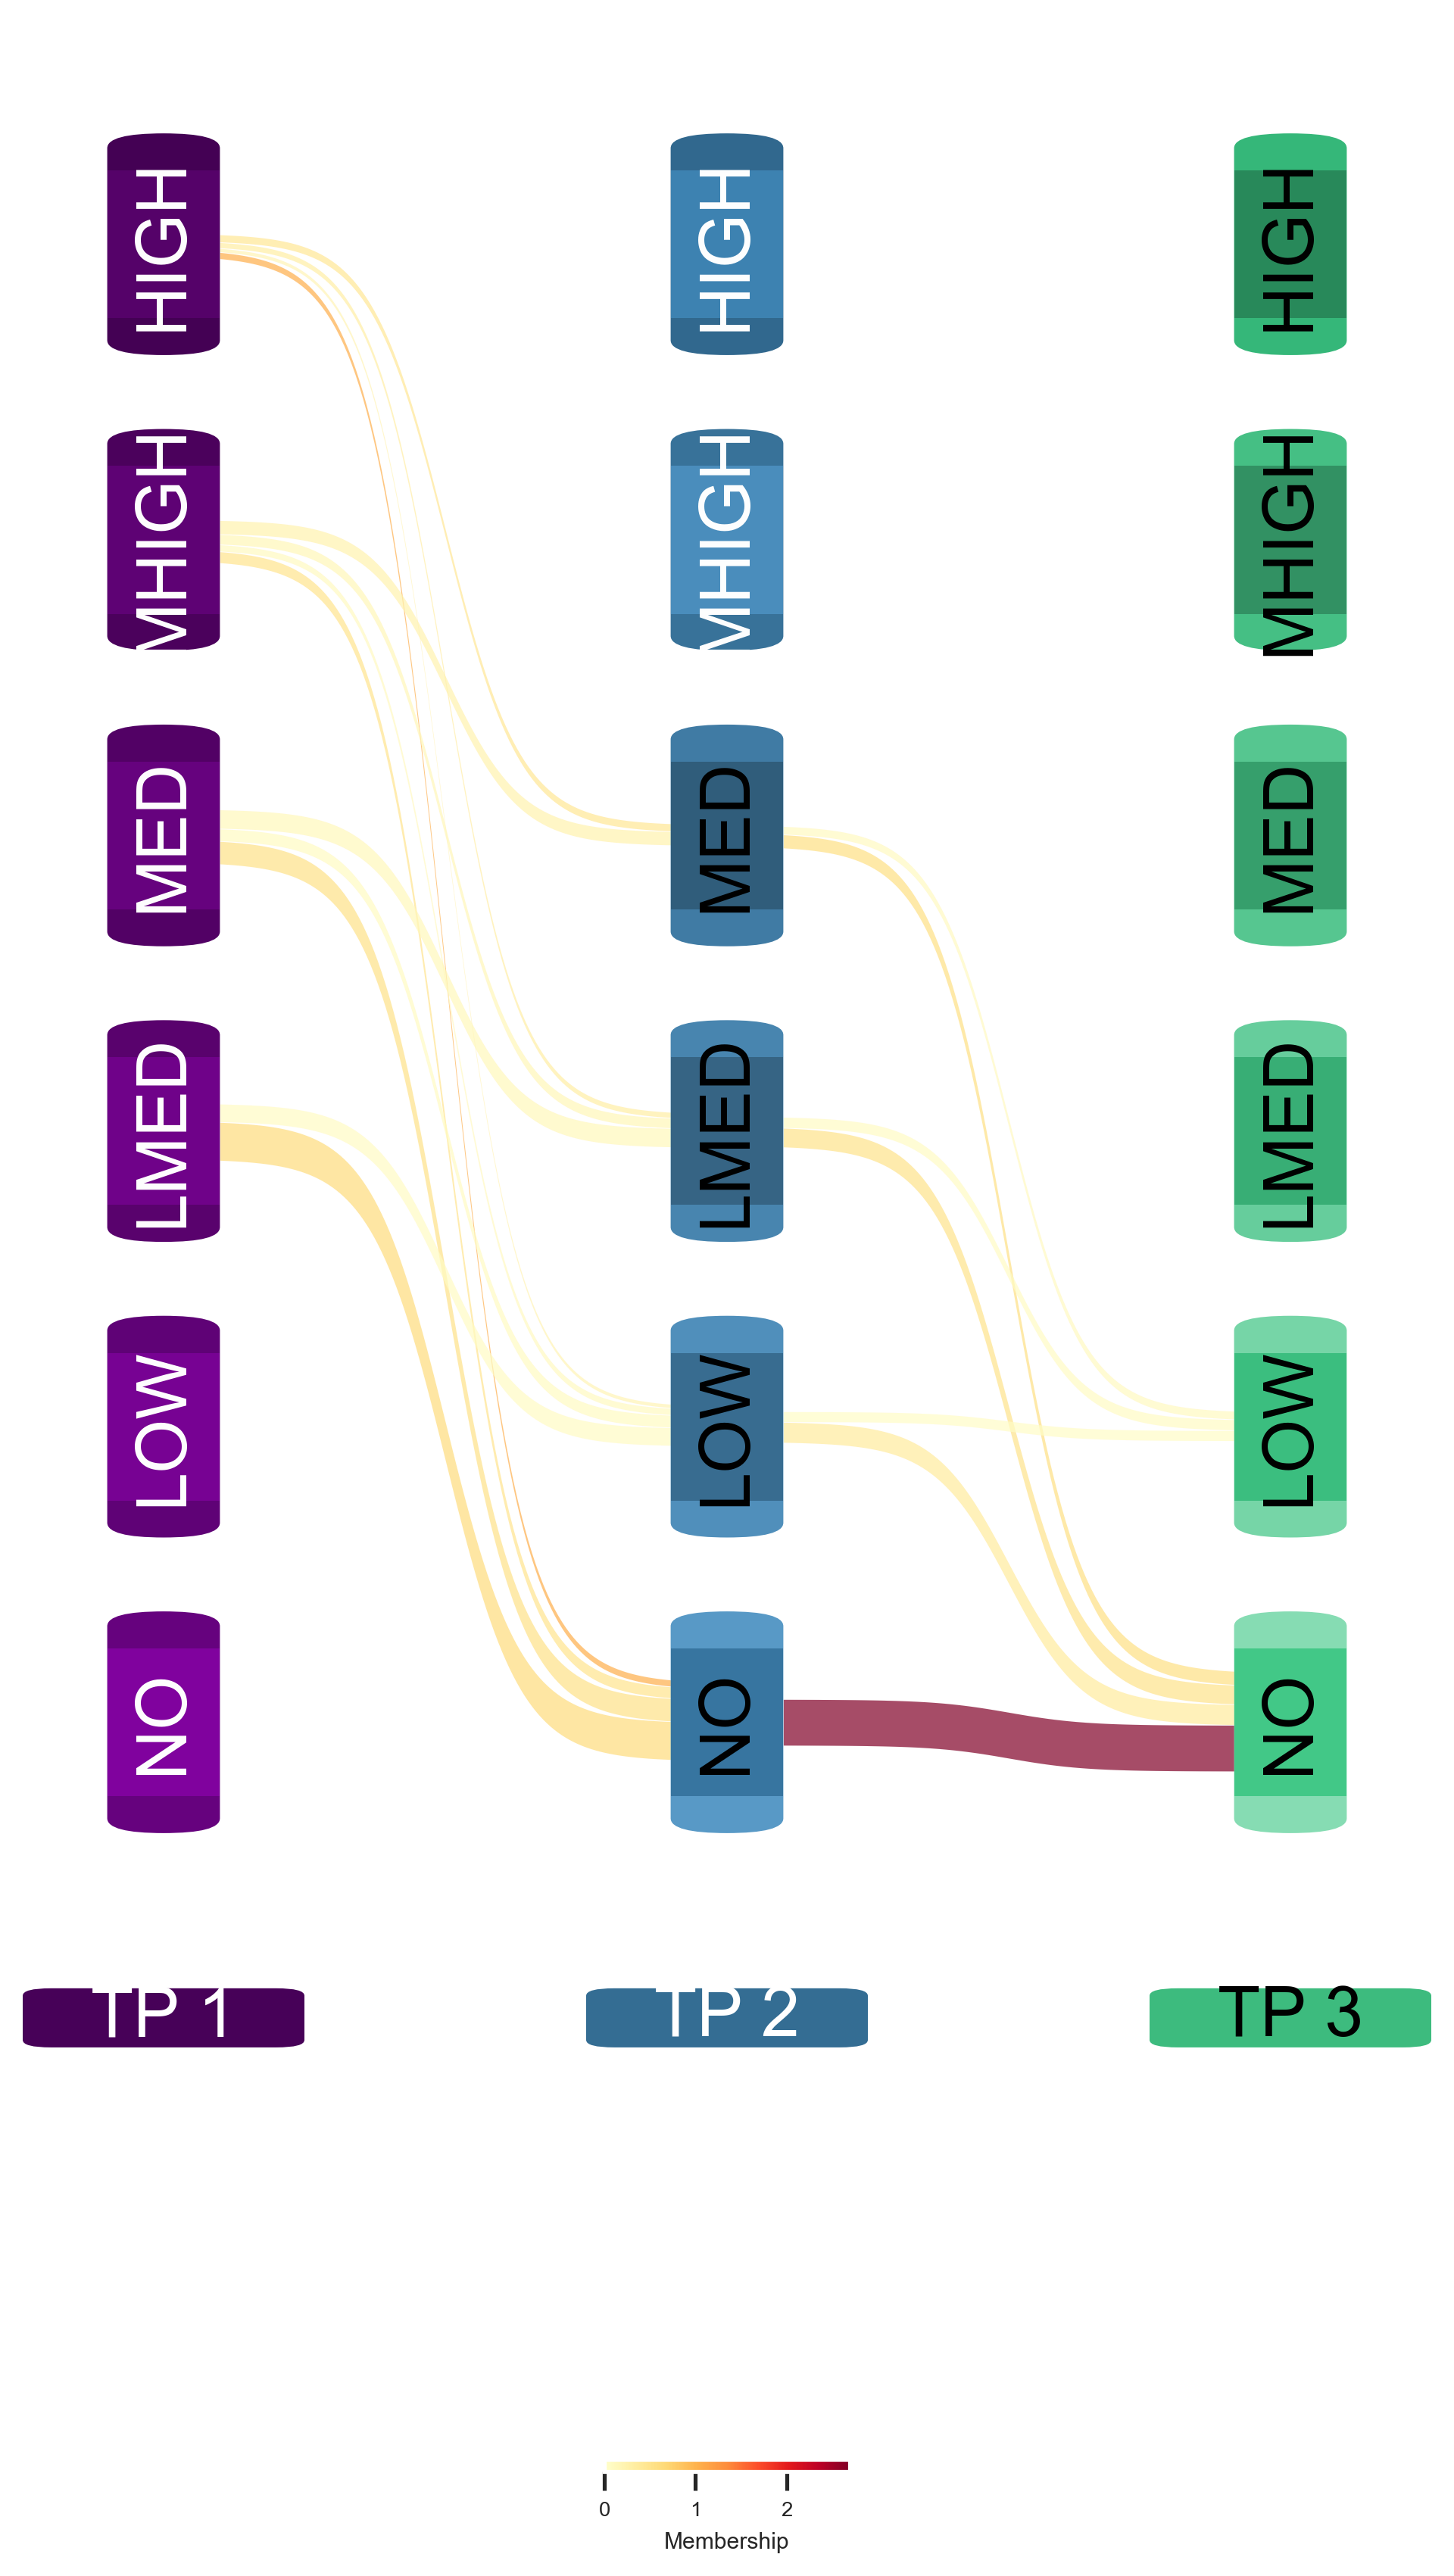

In [26]:
# Visualize ISG genes for selected edges
_ = fa.visualize_genes(genes=isgListShort, use_edges=relEdges, outfile="plots/asympt_isg_flow", figsize=(8,14), seriesColors=sc)

In [27]:
# Pathway analysis using GO biological process gene sets
pwScoresGrpGO = fa.analyse_pathways(genesets_file="go_human.bp.gmt", additional_genesets=[("ISG_SHORT", isgListShort), ("ISG_LONG", isgListLong)], use_edges=relEdges)
pwScoresGrpGO

Loading pathways from go_human.bp.gmt
Identified 12535 pathways


Calculating p-values for groups [1, 2, 3, 4, 10, 50, 100, np.int64(1226)]


pwid                                             pwname    pwFlow  \
7     GO:0010789  meiotic sister chromatid cohesion involved in ...  0.000000   
20    GO:1900101  regulation of endoplasmic reticulum unfolded p...  0.012118   
25    GO:0043610             regulation of carbohydrate utilization  0.000000   
28    GO:0072522    purine-containing compound biosynthetic process  0.000000   
53    GO:0043416  regulation of skeletal muscle tissue regeneration  0.000000   
...          ...                                                ...       ...   
1774  GO:0010976  positive regulation of neuron projection devel...  3.385077   
1860  GO:0001822                                 kidney development  2.543368   
1861  GO:0007568                                              aging  5.186900   
1881  GO:0018108                  peptidyl-tyrosine phosphorylation  4.795330   
2493  GO:0006457                                    protein folding  7.526989   

      pwGenes  allPwFlow    allPwGenes  pw_gene_intersection  pw_coverage  \
7           1  553.08789  11415.000201                     1     0.000000   
20          1  553.08789  11415.000201                     1     0.012118   
25          1  553.08789  11415.000201                     0     0.000000   
28          1  553.08789  11415.000201                     0     0.000000   
53          1  553.08789  11415.000201                     0     0.000000   
...       ...        ...           ...                   ...          ...   
1774      111  553.08789  11415.000201                    73     0.030496   
1860      115  553.08789  11415.000201                    64     0.022116   
1861      146  553.08789  11415.000201                   102     0.035527   
1881      139  553.08789  11415.000201                    99     0.034499   
2493      156  553.08789  11415.000201                   123     0.048250   

      genes_coverage  mean_coverage  pw_coverage_zscore  pw_coverage_pval  \
7           0.000000   0.000000e+00           -0.999756          1.000000   
20          0.000022   2.654865e-07           -0.790575          1.000000   
25          0.000000   0.000000e+00           -0.999756          1.000000   
28          0.000000   0.000000e+00           -0.999756          1.000000   
53          0.000000   0.000000e+00           -0.999756          1.000000   
...              ...            ...                 ...               ...   
1774        0.006120   1.866465e-04           -0.288496          1.000000   
1860        0.004598   1.017013e-04           -0.886893          1.000000   
1861        0.009378   3.331721e-04            0.070725          0.471808   
1881        0.008670   2.991080e-04           -0.002678          1.000000   
2493        0.013609   6.566347e-04            0.979268          0.163724   

      pw_coverage_adj_pval  
7                      1.0  
20                     1.0  
25                     1.0  
28                     1.0  
53                     1.0  
...                    ...  
1774                   1.0  
1860                   1.0  
1861                   1.0  
1881                   1.0  
2493                   1.0  

[12537 rows x 13 columns]

pwid                                             pwname  \
12535   ISG_SHORT                                          ISG_SHORT   
5175   GO:0070106          interleukin-27-mediated signaling pathway   
2460   GO:0035456                        response to interferon-beta   
5995   GO:0032020                          ISG15-protein conjugation   
7070   GO:0035455                       response to interferon-alpha   
12536    ISG_LONG                                           ISG_LONG   
4936   GO:0034340                      response to type I interferon   
397    GO:0045071    negative regulation of viral genome replication   
988    GO:0042776  proton motive force-driven mitochondrial ATP s...   
7189   GO:0036261             7-methylguanosine cap hypermethylation   
987    GO:0009060                                aerobic respiration   
396    GO:0009615                                  response to virus   
8673   GO:0019941   modification-dependent protein catabolic process   
3296   GO:1903241                    U2-type prespliceosome assembly   
842    GO:0034134             toll-like receptor 2 signaling pathway   
5173   GO:0060339  negative regulation of type I interferon-media...   
1267   GO:0070585              protein localization to mitochondrion   
2239   GO:0006122  mitochondrial electron transport, ubiquinol to...   
3718   GO:0060333      type II interferon-mediated signaling pathway   
5303   GO:0051101                          regulation of DNA binding   

         pwFlow  pwGenes  allPwFlow    allPwGenes  pw_gene_intersection  \
12535  4.343160       14  553.08789  11415.000201                    14   
5175   1.606055        7  553.08789  11415.000201                     7   
2460   1.985547       11  553.08789  11415.000201                    10   
5995   1.270035        6  553.08789  11415.000201                     6   
7070   1.831392       11  553.08789  11415.000201                     9   
12536  7.783241       55  553.08789  11415.000201                    40   
4936   1.539413        9  553.08789  11415.000201                     9   
397    6.109100       44  553.08789  11415.000201                    39   
988    7.087340       64  553.08789  11415.000201                    63   
7189   1.165208        8  553.08789  11415.000201                     8   
987    6.725154       66  553.08789  11415.000201                    66   
396    9.708621      109  553.08789  11415.000201                    88   
8673   1.173235        9  553.08789  11415.000201                     8   
3296   2.654844       24  553.08789  11415.000201                    24   
842    0.757273        6  553.08789  11415.000201                     6   
5173   2.053717       19  553.08789  11415.000201                    16   
1267   1.169738       11  553.08789  11415.000201                     8   
2239   1.484095       14  553.08789  11415.000201                    13   
3718   1.233274       12  553.08789  11415.000201                    11   
5303   0.701265        6  553.08789  11415.000201                     6   

       pw_coverage  genes_coverage  mean_coverage  pw_coverage_zscore  \
12535     0.310226        0.007853       0.002436           13.380049   
5175      0.229436        0.002904       0.000666            7.720510   
2460      0.180504        0.003590       0.000648            7.054415   
5995      0.211672        0.002296       0.000486            7.013685   
7070      0.166490        0.003311       0.000551            6.371044   
12536     0.141513        0.014072       0.001991            6.234784   
4936      0.171046        0.002783       0.000476            5.397159   
397       0.138843        0.011045       0.001534            5.022889   
988       0.110740        0.012814       0.001419            4.423949   
7189      0.145651        0.002107       0.000307            4.386705   
987       0.101896        0.012159       0.001239            3.903572   
396       0.089070        0.017553       0.00156

Index(['pwid', 'pwname', 'pwFlow', 'pwGenes', 'allPwFlow', 'allPwGenes',
       'pw_gene_intersection', 'pw_coverage', 'genes_coverage',
       'mean_coverage', 'pw_coverage_zscore', 'pw_coverage_pval',
       'pw_coverage_adj_pval'],
      dtype='object')
False
False
(20, 14)


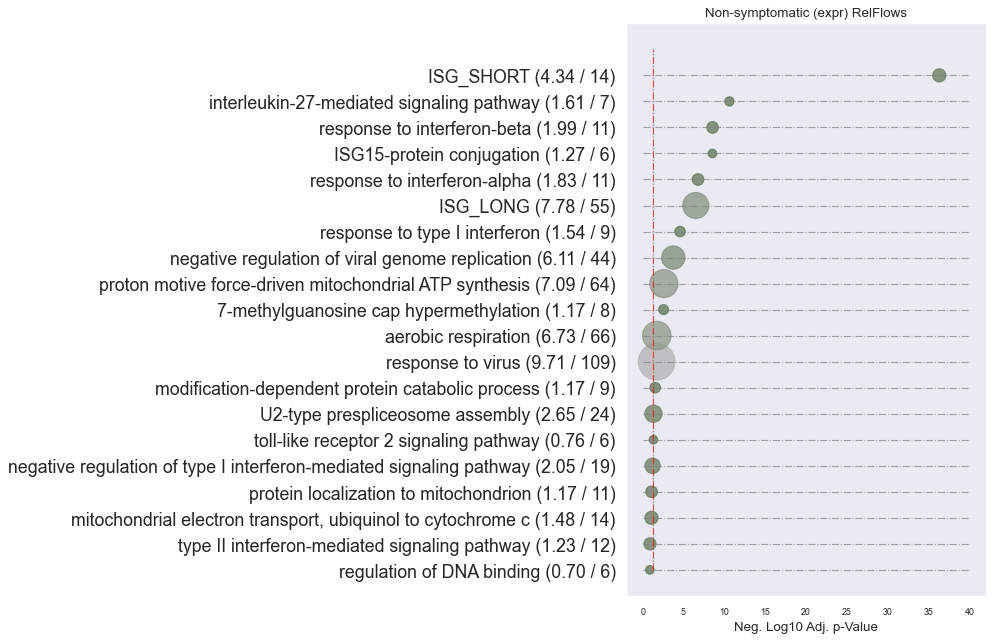

In [28]:
# Select and plot top GO pathways for non-symptomatic group
selPWsGrpGO = pwScoresGrpGO[(pwScoresGrpGO["pw_coverage_adj_pval"] < 1) & (pwScoresGrpGO["pwGenes"] > 5)].sort_values("pw_coverage_adj_pval", ascending=True).head(20)
display(selPWsGrpGO)
fa.plotORAresult(selPWsGrpGO, "Non-symptomatic (expr) RelFlows", numResults=20, figsize=(8,8), outfile="plots/asympt_go")

In [29]:
# Load GO pathways for further analysis
go = fa.get_pathways("go_human.bp.gmt")

Loading pathways from go_human.bp.gmt
Identified 12535 pathways


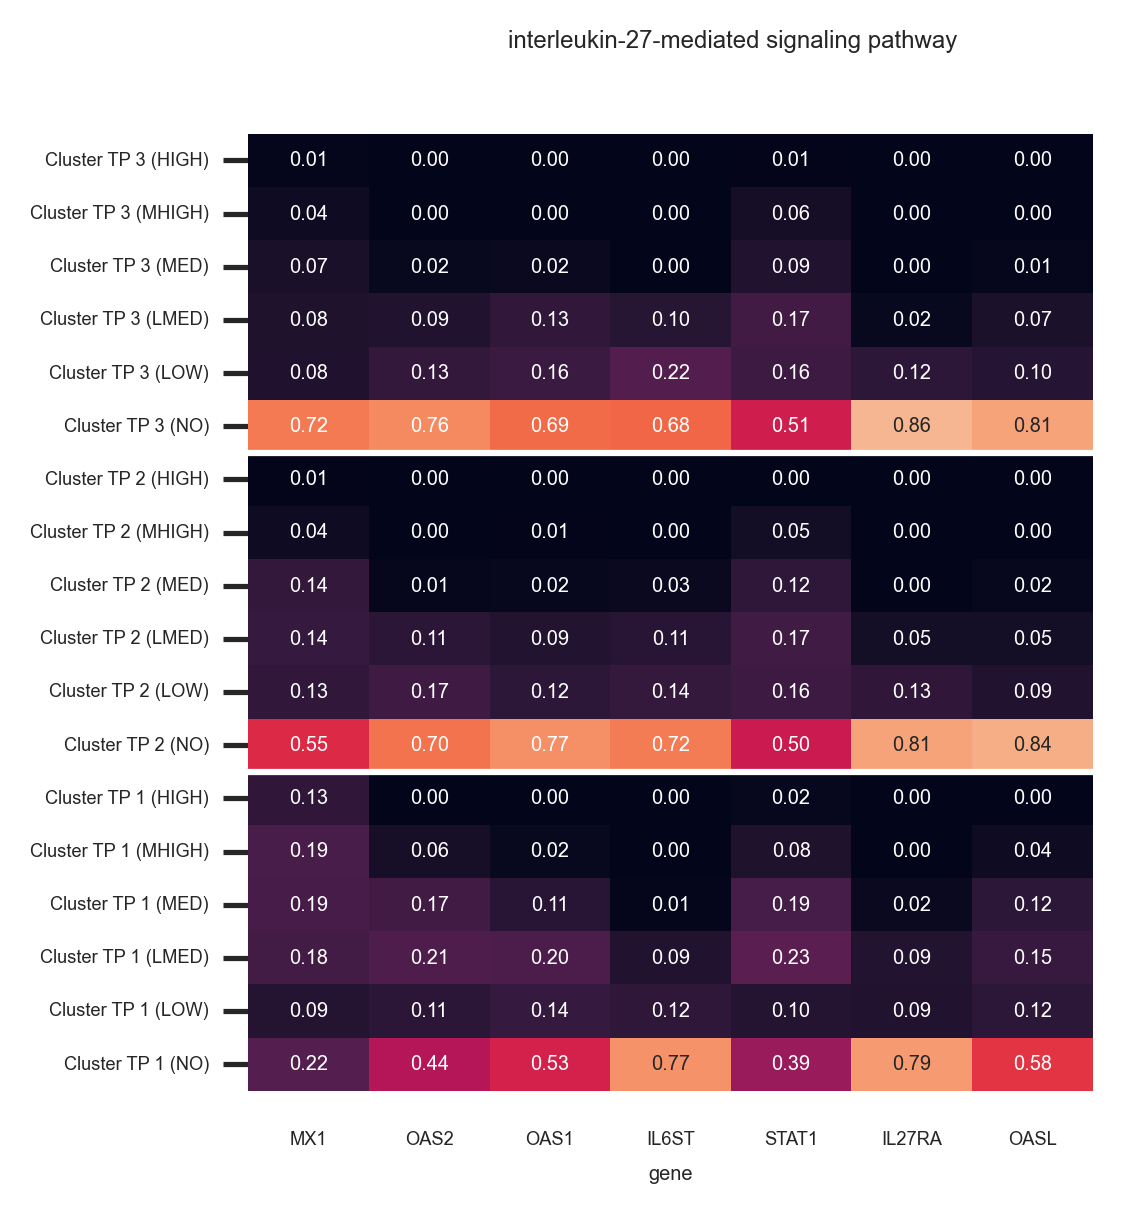

In [30]:
# Plot state memberships for a specific GO pathway
def_memberships = fa.plot_state_memberships(go["GO:0070106"][1], name=go["GO:0070106"][0], figsize=(4,4), outfile="plots/GO_0070106_memberships")

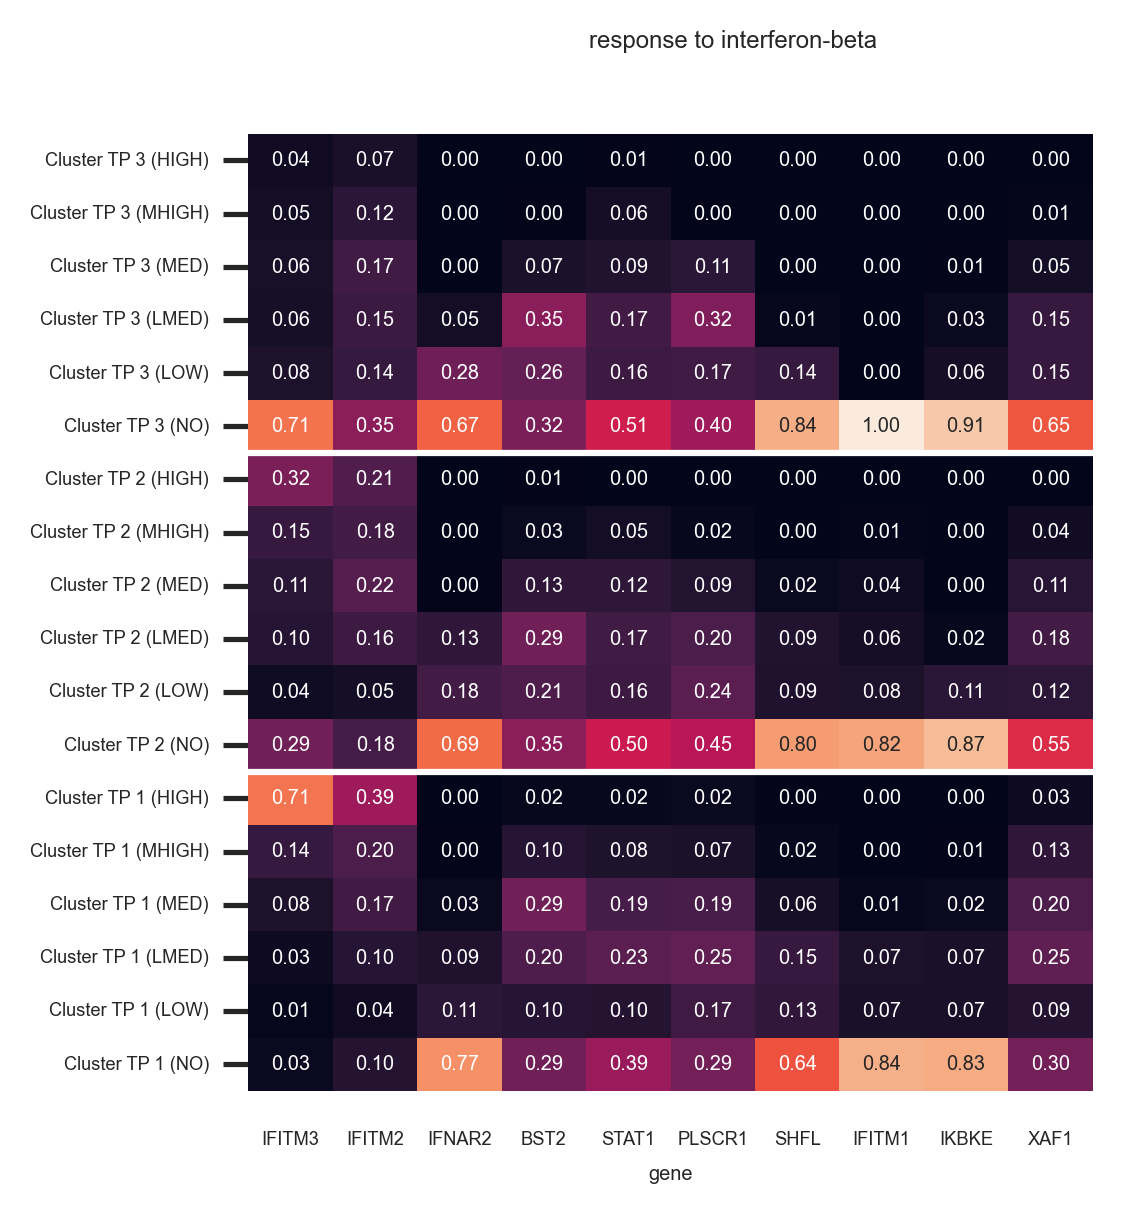

In [31]:
# Plot state memberships for another GO pathway
fa.plot_state_memberships(go["GO:0035456"][1], name=go["GO:0035456"][0], figsize=(4,4), outfile="plots/GO_0035456_memberships")

In [32]:
# ...existing code...